In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import re
import glob
import h5py
from bids import BIDSLayout
import nibabel as nib
from PIL import Image
import json
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

dir2 = os.path.abspath('..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
from tc2see import load_data

### Global Variables

```
ROIs = {
    "FFC": [18],"V1": [1],"V2": [4],"V3": [5],"V3A": [13],"V3B": [19],"V3CD": [158],"V4": [6],"V6": [3],"V7": [16],
    "V8": [7], "VMV1": [153],"VMV2": [160],"VMV3": [154],"LO1": [20],"LO2": [21],"PIT": [22],"VVC": [163], "140": [140], "11":[11],
    "85": [85], "83":[83], "82": [82], "87": [87], "V1_V2_V3_V4": [1,4,5,6], "V1_V2": [1,4], "PIT_FFC_VVC": [22, 18, 163]
}
```

In [2]:
dataset_root = Path('E:\\fmri_processing\\results')
dataset_path = dataset_root
derivatives_path = dataset_path / 'derivatives_TC2See'
stimulus_images = h5py.File(derivatives_path / 'stimulus-images.hdf5', 'r')
stimulus_id_map = {i: name for i, name in enumerate(stimulus_images.attrs['stimulus_names'])}
images_dir = Path("E:/Decoding/bird_data/bird_images/docs/cropped")

expertise_groups   = ['low', 'high']
avg_duplicates = True

subject_strs_dict = {
    'low':      ['low', ['06', '15', '20', '21', '23', '28', '29', '32', '39']],
    'moderate': ['moderate', ['05', '07', '10', '14', '17', '18', '19', '22', '25', '30', '31', '33', '34', '37']],
    'high':     ['high', ['08', '09', '11', '12', '16', '24', '26', '27', '35', '36', '38']]
}


num_runs = 6
ROIs = ["V1","V2","V3","V3A","V3B","V3CD","V4","V6","V7","V8","VMV1","VMV2","VMV3","LO1","LO2","PIT","FFC","VVC","PH","PEF","a9-46v","p9-46v","IFSa","9a"]

In [3]:
# stimulus_ids = [101, 80, 94, 143, 142, 141, 140, 124, 123, 114, 144, 11, 20, 34, 64, 61, 60, 52, 0, 103, 84, 83, 82, 110, 74, 111, 113, 112, 73, 71, 72, 4, 3, 2, 1, 63, 62, 70, 130, 24, 23, 44, 43, 42, 41, 40, 104, 102, 93, 92, 91, 90, 81, 132, 121, 120, 134, 133, 131, 122, 30, 22, 21, 14, 13, 12, 10, 31, 32, 33, 54, 53, 51, 50, 100, 154, 250, 291, 290, 283, 282, 152, 293, 294, 252, 243, 261, 260, 264, 263, 262, 173, 171, 170, 164, 162, 161, 181, 204, 203, 200, 201, 253, 244, 242, 240, 241, 281, 172, 163, 160, 153, 150, 174, 194, 192, 190, 224, 284, 183, 220, 151, 180, 182, 193, 191, 233, 232, 280, 211, 234, 231, 223, 273, 271, 270, 274, 222, 214, 213, 212, 210, 221, 251, 230, 254, 292, 272, 202, 184]

# sparrow_sparrow = ['sparrow_sparrow', [images_dir / f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(62, 75)) if img_num not in [65, 66, 69]], [f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(62, 75)) if img_num not in [65, 66, 69]]]
# warbler_warbler = ['warbler_warbler', [images_dir / f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(137, 150)) if img_num not in [139]], [f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(137, 150)) if img_num not in [139]]]

# import shutil

# for folder, path_list, im_names in [sparrow_sparrow, warbler_warbler]:
#     path_to_save = Path("E:/fmri_processing/results/visualization/correlated_imgs")

#     for im_path, im_name in zip(path_list, im_names):
#         current_im_location = im_path
#         destination_im_location = path_to_save / folder / im_name
        
#         shutil.copy(current_im_location, destination_im_location)

# stimulus_ids = [101, 80, 94, 143, 142, 141, 140, 124, 123, 114, 144, 11, 20, 34, 64, 61, 60, 52, 0, 103, 84, 83, 82, 110, 74, 111, 113, 112, 73, 71, 72, 4, 3, 2, 1, 63, 62, 70, 130, 24, 23, 44, 43, 42, 41, 40, 104, 102, 93, 92, 91, 90, 81, 132, 121, 120, 134, 133, 131, 122, 30, 22, 21, 14, 13, 12, 10, 31, 32, 33, 54, 53, 51, 50, 100, 154, 250, 291, 290, 283, 282, 152, 293, 294, 252, 243, 261, 260, 264, 263, 262, 173, 171, 170, 164, 162, 161, 181, 204, 203, 200, 201, 253, 244, 242, 240, 241, 281, 172, 163, 160, 153, 150, 174, 194, 192, 190, 224, 284, 183, 220, 151, 180, 182, 193, 191, 233, 232, 280, 211, 234, 231, 223, 273, 271, 270, 274, 222, 214, 213, 212, 210, 221, 251, 230, 254, 292, 272, 202, 184]

# # sparrow = ['sparrow', [images_dir / f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(5, 15))], [f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(5, 15))]]
# warbler = ['warbler', [images_dir / f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in [75, 88]], [f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in [75, 88]]]

# for folder, path_list, im_names in [ warbler]:
#     path_to_save = Path("E:/fmri_processing/results/visualization/uncorrelated_imgs")

#     for im_path, im_name in zip(path_list, im_names):
#         current_im_location = im_path
#         destination_im_location = path_to_save / folder / im_name
        
#         shutil.copy(current_im_location, destination_im_location)

In [3]:
model_name = 'ViT-B=32'
embedding_name = 'embedding' 

with h5py.File(derivatives_path / f'{model_name}-features.hdf5', 'r') as f:
    stimulus = f[embedding_name][:]

stimulus_df = pd.DataFrame(stimulus)
stimulus_df['stimulus_ids'] = stimulus_df.index
stimulus_df['stimulus_category'] = stimulus_df['stimulus_ids'].apply(lambda x: "Sparrow" if "Sparrow" in stimulus_id_map[x] else "Warbler")
grouped_stimuli = stimulus_df.groupby("stimulus_category")

cluster_lookup = {}

for group_category, group in grouped_stimuli:
    numeric_data = group.drop(columns=['stimulus_ids', 'stimulus_category'])
    stim_ids = group['stimulus_ids'].values
    stim_cats = group['stimulus_category'].values

    kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto')
    clusters = kmeans.fit_predict(numeric_data)

    for stim_id, cluster in zip(stim_ids, clusters):
        cluster_lookup[stim_id] = cluster

In [5]:
# group_RDMs_corr = {}
# from scipy.stats import pearsonr

# for group in expertise_groups:
#     group_RDMs_corr[group] = {}
#     expertise_level_str = subject_strs_dict[group][0]
#     subject_strs        = subject_strs_dict[group][1]

#     for ROI in ROIs:
#         all_sub_corr_mats = []

#         for subject_str in subject_strs:
#             roi_path = Path("E:/Decoding/fmri-preprocessing/img_bold_arrays") / f"sub_{subject_str}" / f"corr_matrices_avg_dups_2" / "ROIs" / ROI

#             correlation_file_name = roi_path / "correlation_matrix.npy"
#             sub_roi_data = np.load(correlation_file_name)

#             correlation_matrix = np.corrcoef(sub_roi_data)
#             all_sub_corr_mats.append(correlation_matrix)

#             def flatten_upper_tri(matrix):
#                 upper_tri = matrix[np.triu_indices(matrix.shape[0], k=1)]
#                 return upper_tri

#         flattened_matrices = [flatten_upper_tri(matrix) for matrix in all_sub_corr_mats]

#         # Compute the correlation between each pair of matrices
#         def compute_matrix_correlations(flattened_matrices):
#             n = len(flattened_matrices)
#             correlations = np.zeros((n, n))
#             for i in range(n):
#                 for j in range(i, n):
#                     if i == j:
#                         correlations[i, j] = 1.0
#                     else:
#                         corr, _ = pearsonr(flattened_matrices[i], flattened_matrices[j])
#                         correlations[i, j] = corr
#                         correlations[j, i] = corr
#             return correlations

#         correlation_between_matrices = compute_matrix_correlations(flattened_matrices)
        
#         group_RDMs_corr[group][ROI] = correlation_between_matrices



In [4]:
group_RDMs = {}

for group in expertise_groups:
    group_RDMs[group] = {}
    expertise_level_str = subject_strs_dict[group][0]
    subject_strs        = subject_strs_dict[group][1]

    for ROI in ROIs:
        all_sub_corr_mats = []

        for subject_str in subject_strs:
            roi_path = Path("E:/Decoding/fmri-preprocessing/img_bold_arrays") / f"sub_{subject_str}" / f"corr_matrices_avg_dups_2" / "ROIs" / ROI
            stim_ids_path = Path("E:/Decoding/fmri-preprocessing/img_bold_arrays") / f"sub_{subject_str}" / f"corr_matrices_avg_dups_2"

            if not roi_path.exists():
                roi_path.mkdir(parents=True, exist_ok=True)

                try:
                    sub_roi_data = pd.read_parquet(f'E:/Decoding/fmri-preprocessing/img_bold_arrays/sub_{subject_str}/img_roi_dfs/ROIs/{ROI}/roi_bold_for_imgs.parquet')
                    
                    if avg_duplicates:
                        sub_roi_data['stimulus_category'] = sub_roi_data['stimulus_category'].apply(lambda x: 1 if x == "Sparrow" else 2)
                        sub_roi_data = sub_roi_data.groupby('stimulus_ids').mean().reset_index()
                        sub_roi_data['stimulus_category'] = sub_roi_data['stimulus_category'].apply(lambda x: "Sparrow" if x == 1 else "Warbler")

                    sub_roi_data = sub_roi_data.sort_values(by='stimulus_category')
                    sub_roi_data['cluster'] = sub_roi_data['stimulus_ids'].apply(lambda x: cluster_lookup[x])
                    sub_roi_data = sub_roi_data.sort_values(by=['stimulus_category', 'cluster'])

                    stim_ids_cats = sub_roi_data[['stimulus_ids', 'stimulus_category']].to_numpy()
                    sub_roi_data = sub_roi_data.drop(columns=['stimulus_ids', 'stimulus_category'])

                    correlation_matrix = np.corrcoef(sub_roi_data)
                    all_sub_corr_mats.append(correlation_matrix)
                    
                    correlation_file_name = roi_path / "correlation_matrix.npy"
                    np.save(correlation_file_name, correlation_matrix)
                    
                    stim_ids_file_name = stim_ids_path / "stim_ids.npy"
                    if not stim_ids_file_name.exists():
                        np.save(stim_ids_file_name, stim_ids_cats)

                except:
                    print(f"ROI not available: {ROI} for subject {subject_str}")
                    continue
            else:
                correlation_file_name = roi_path / "correlation_matrix.npy"
                sub_roi_data = np.load(correlation_file_name)

                correlation_matrix = np.corrcoef(sub_roi_data)
                all_sub_corr_mats.append(correlation_matrix)
            

        all_sub_corr_mats_avg = np.mean(all_sub_corr_mats, axis=0, keepdims=True)[0]  ### np.squeeze instead of [0]

        np.fill_diagonal(all_sub_corr_mats_avg, 0)

        group_RDMs[group][ROI] = all_sub_corr_mats_avg


## Single Group Analysis

In [ ]:
group_1 = 'high'
expertise_level_str = subject_strs_dict[group_1][0]

for ROI in ROIs:

    group_1_RDM = group_RDMs[group_1][ROI]

    mask = np.triu(np.ones_like(group_1_RDM, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(group_1_RDM, mask=mask, annot=False, cmap='seismic', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix Heatmap for {ROI} ({expertise_level_str})')
    # plt.savefig(f'correlation_matrices/high/correlation_matrix_heatmap_{ROI}_{expertise_level_str}.png')
    plt.show()

## Group Difference Analysis

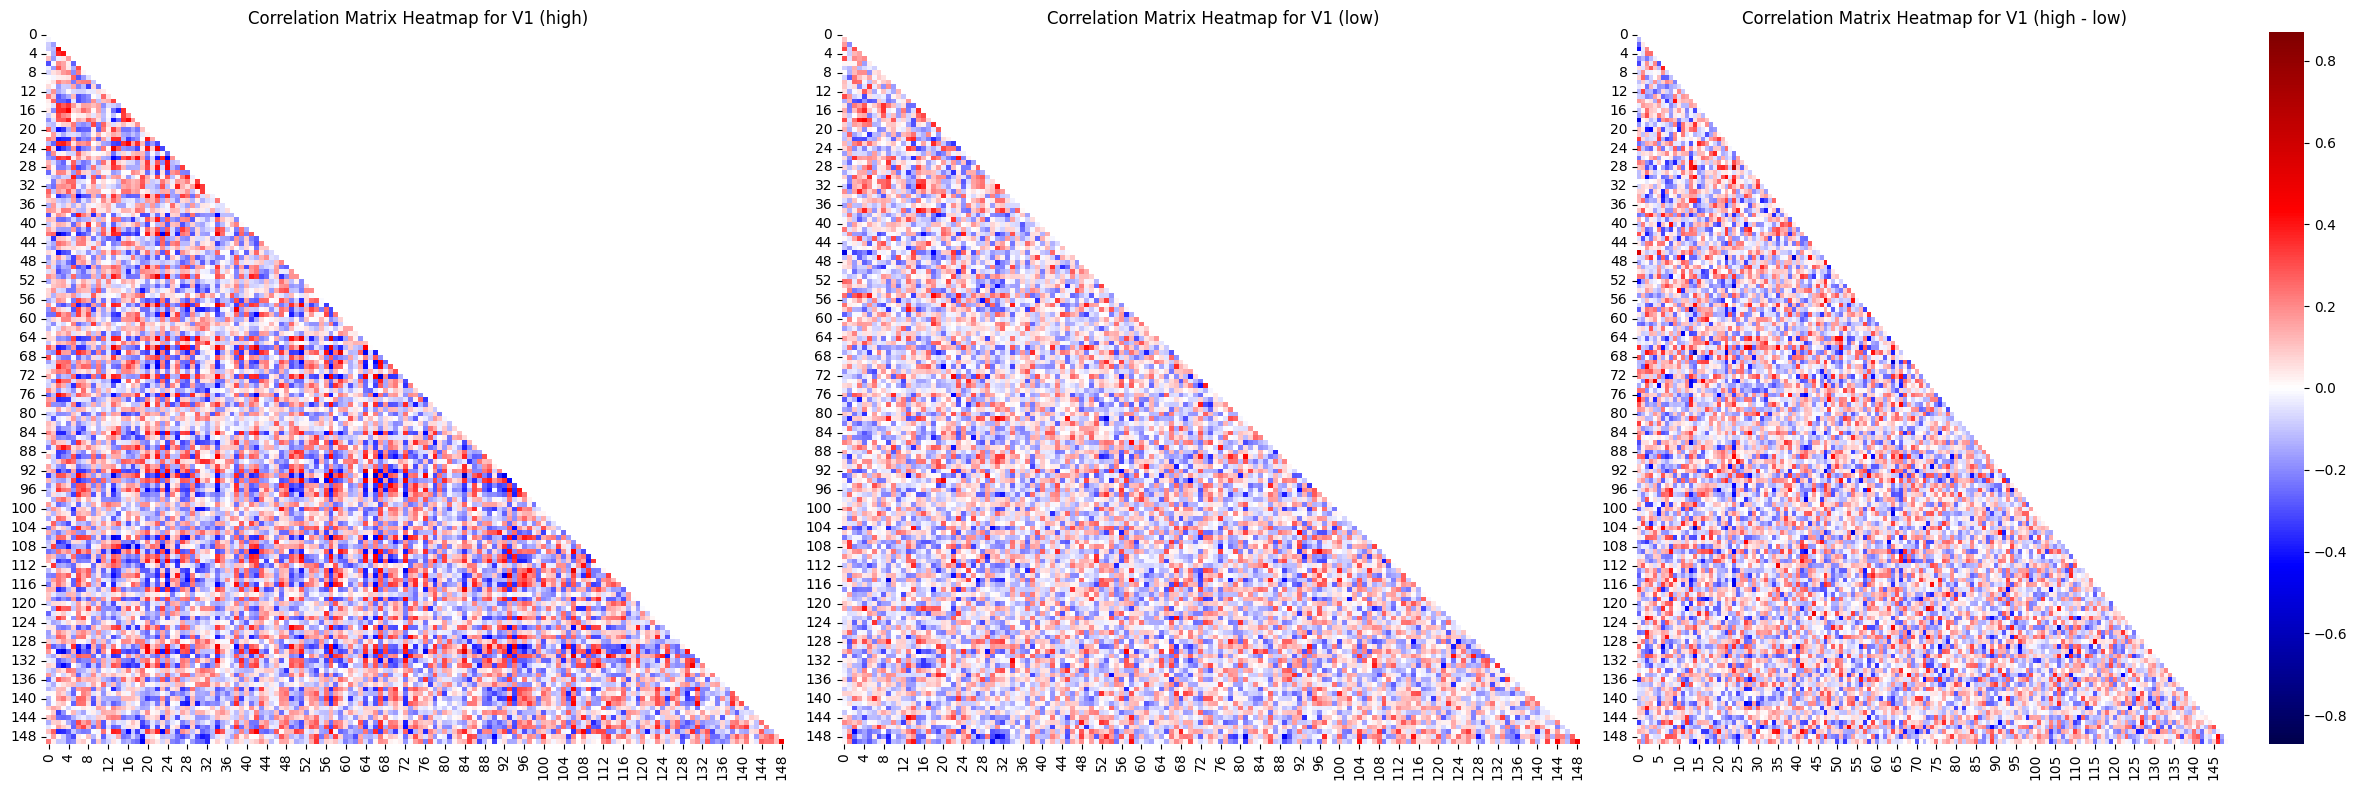

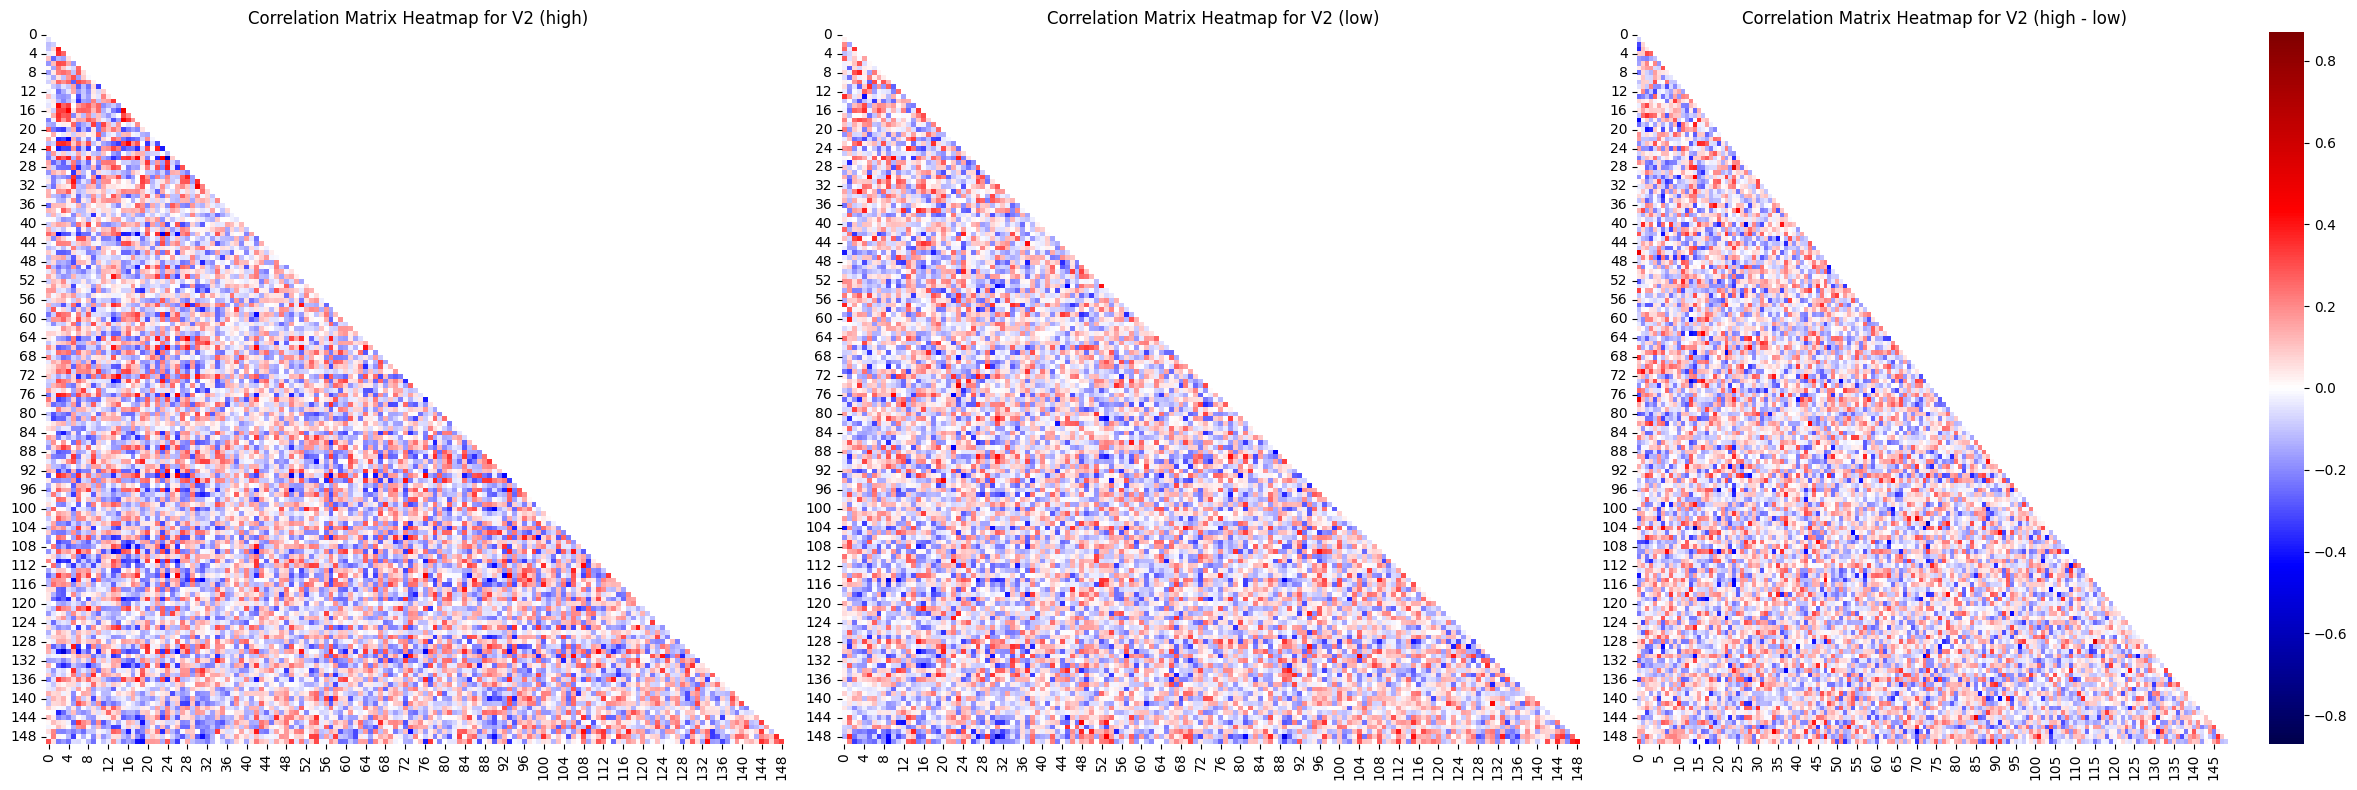

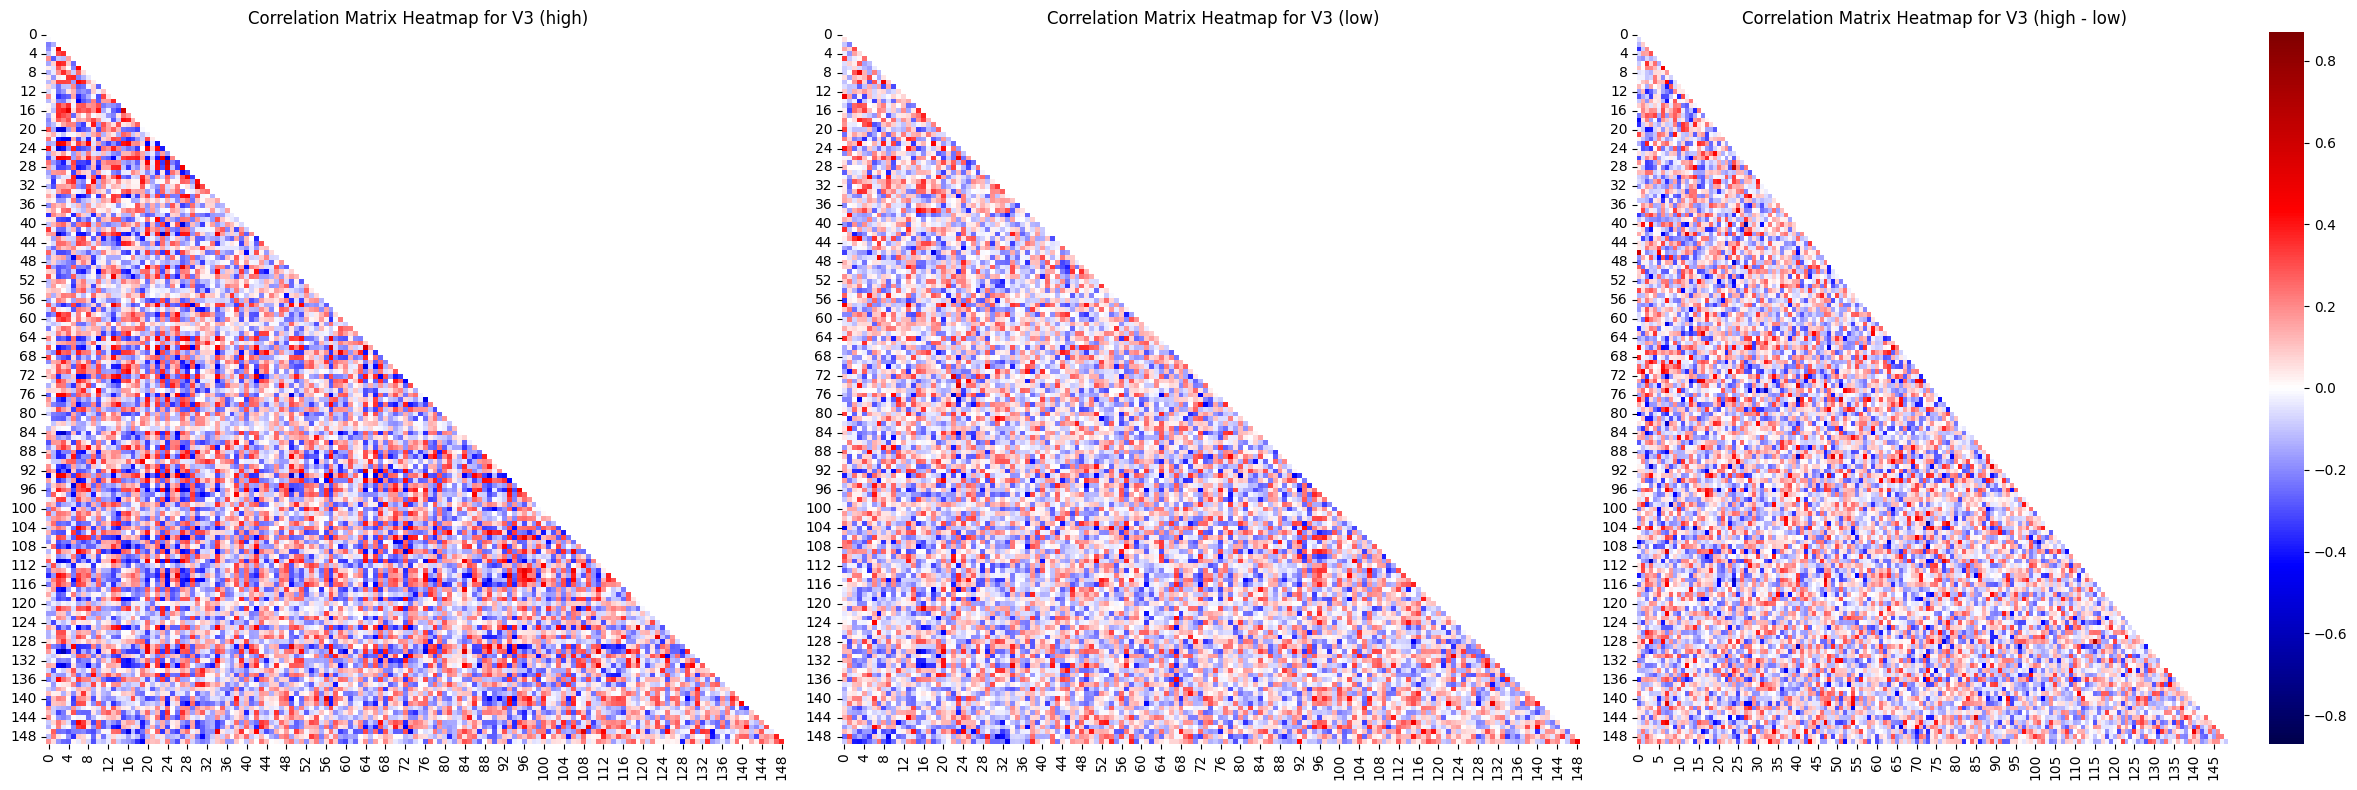

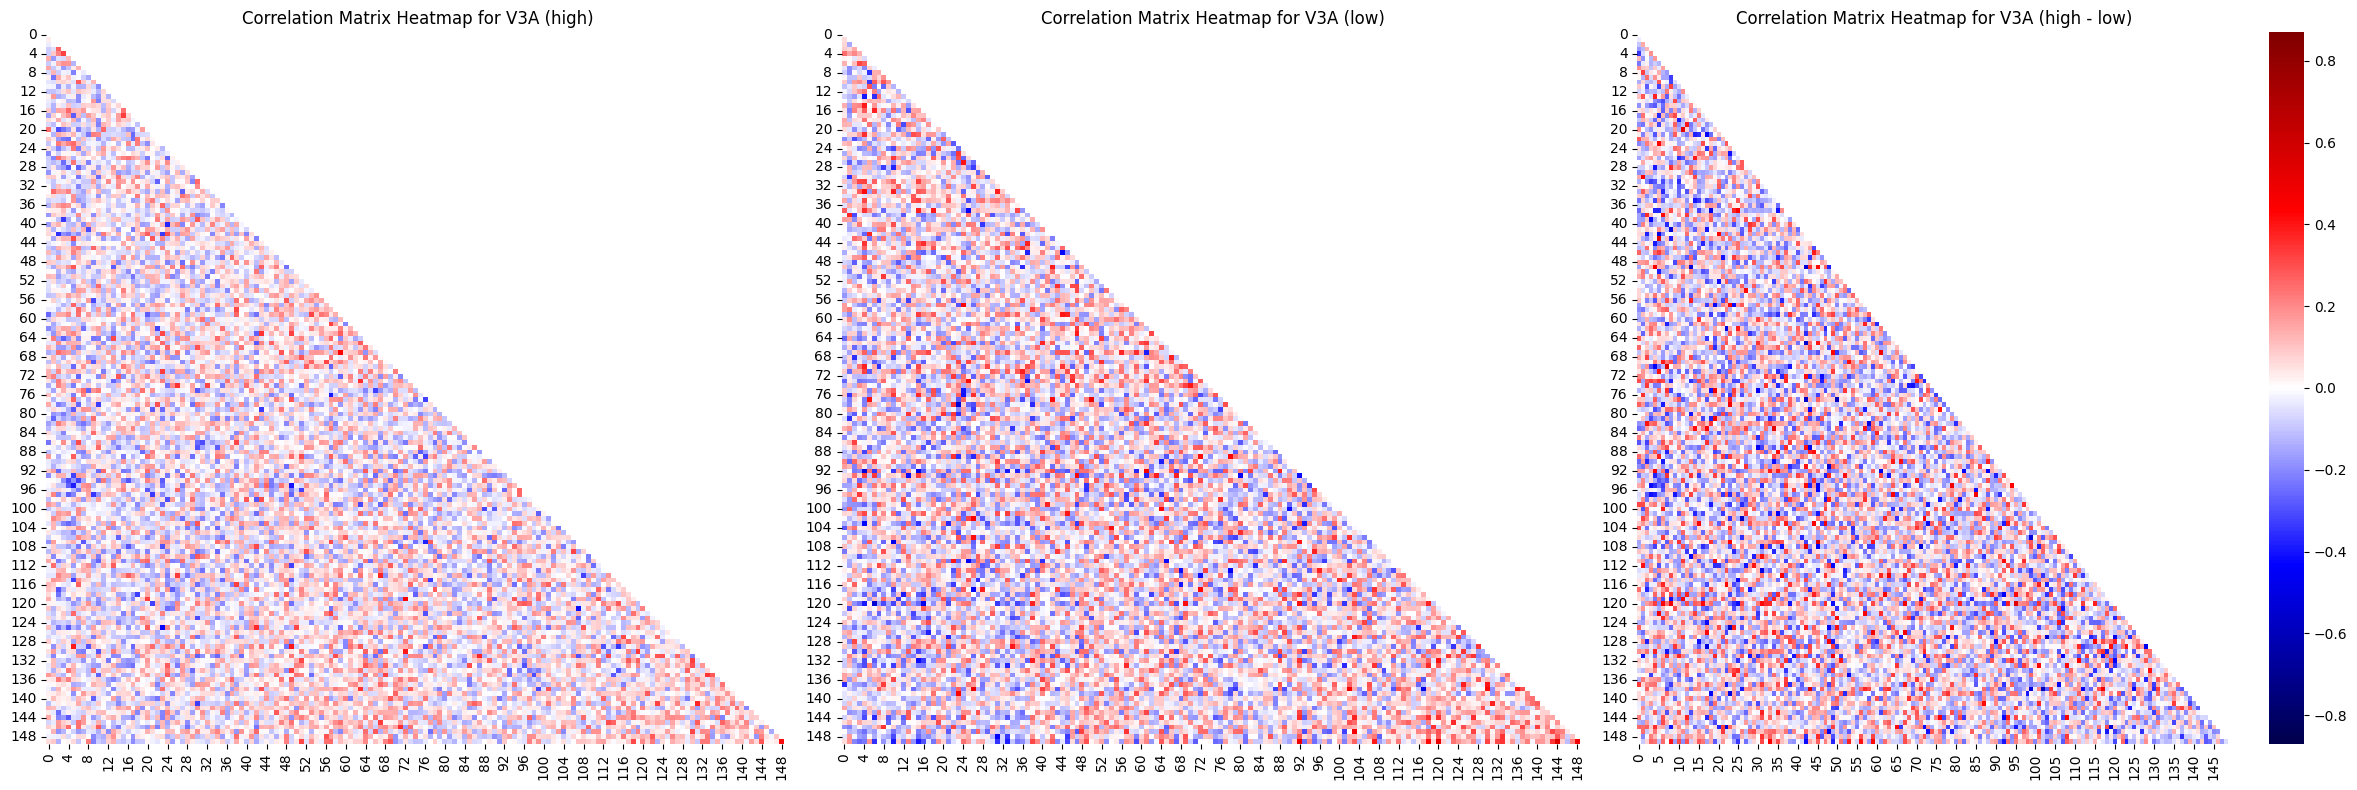

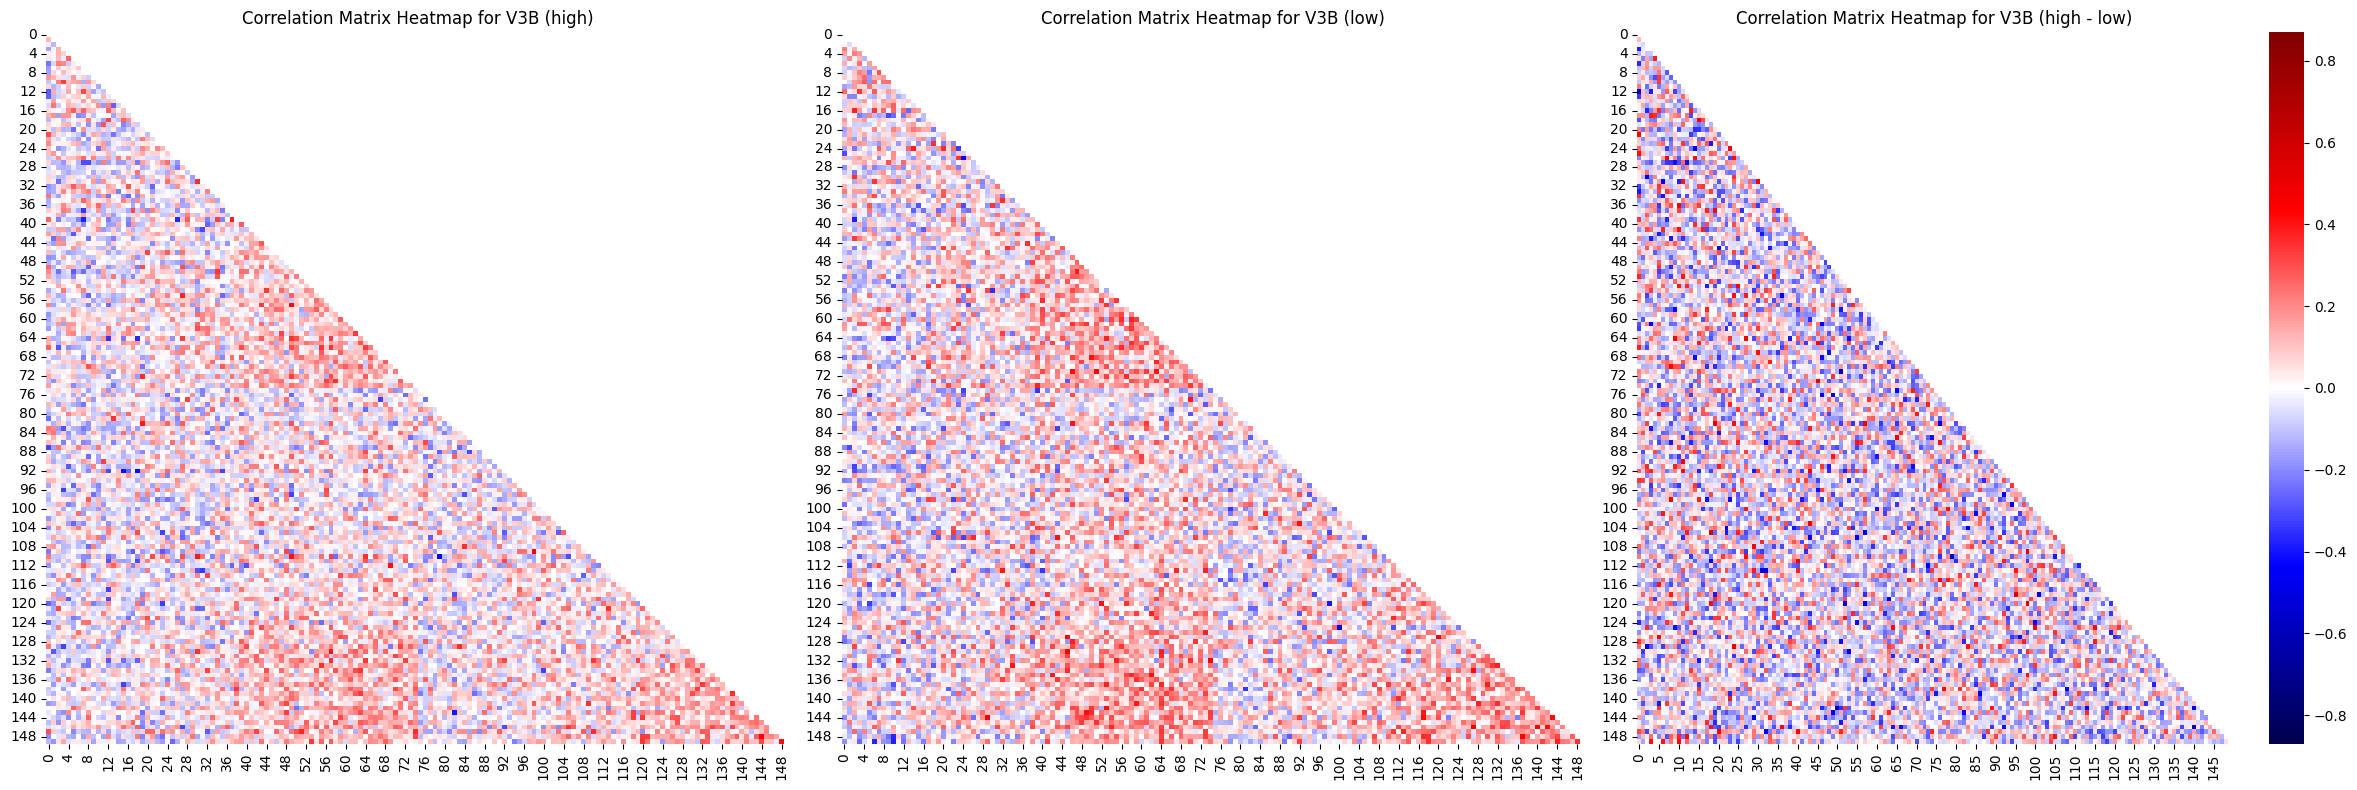

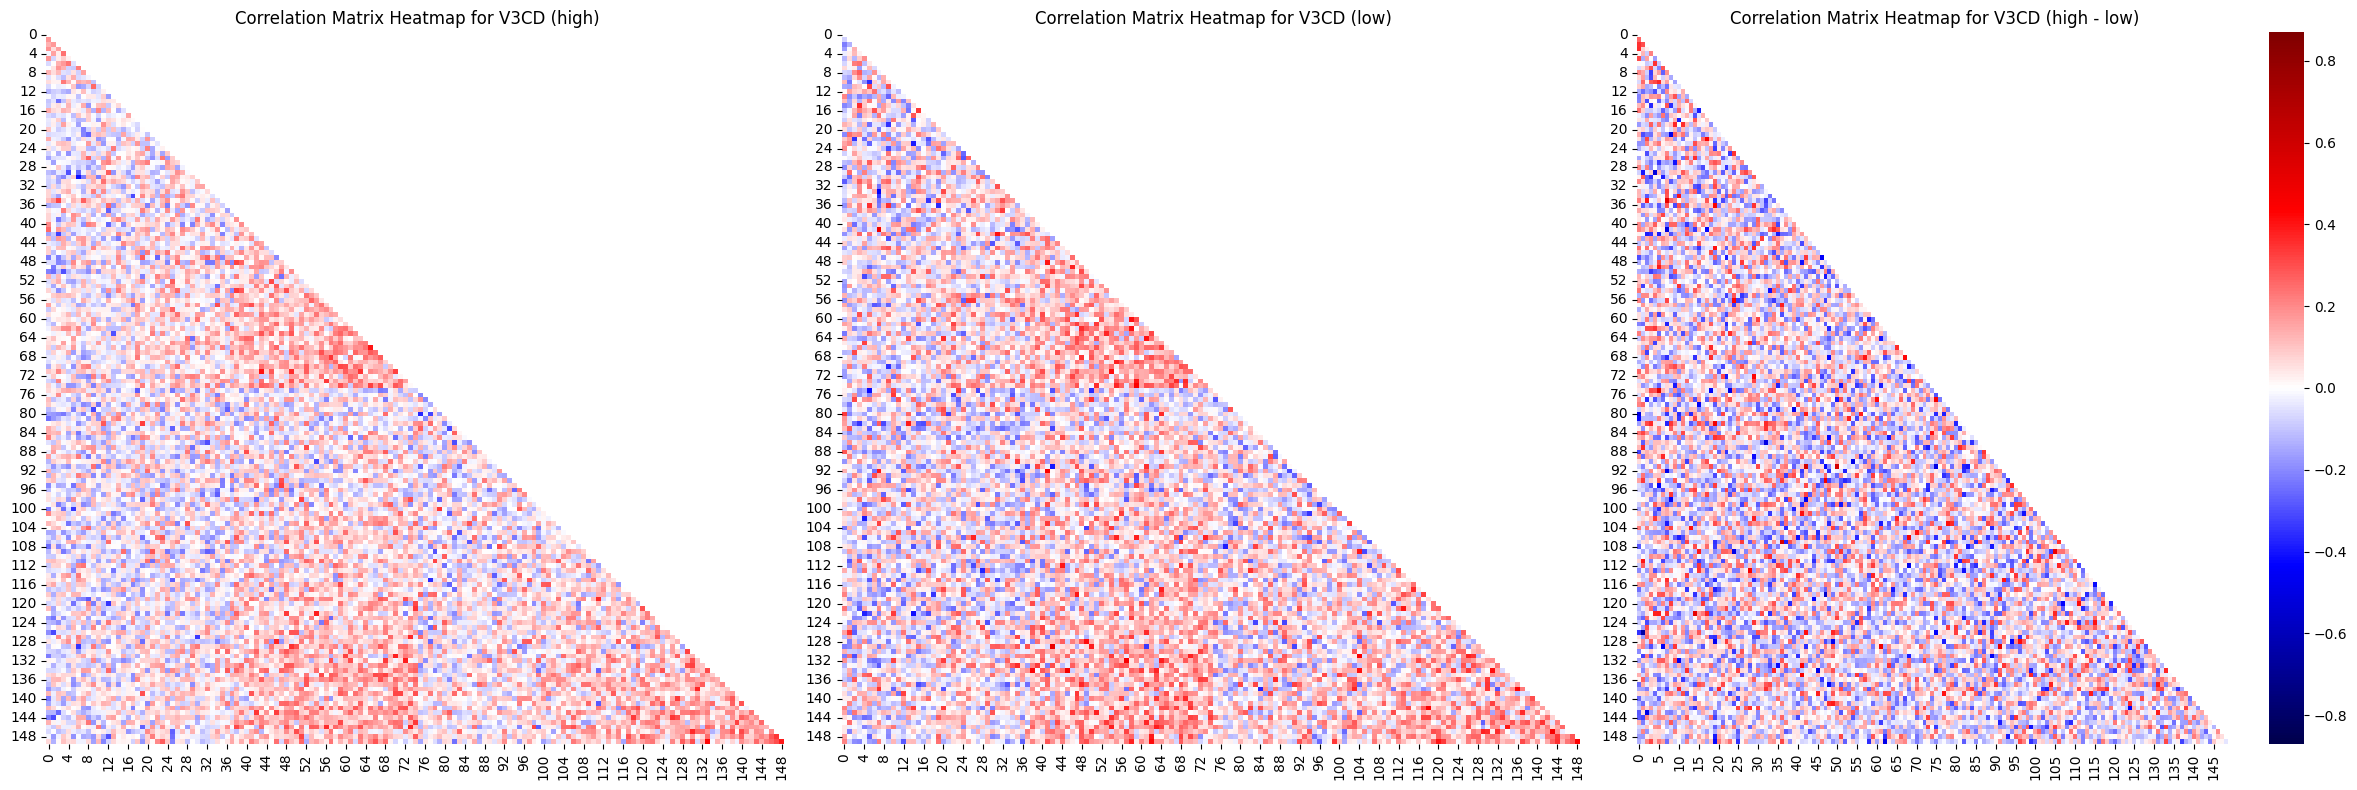

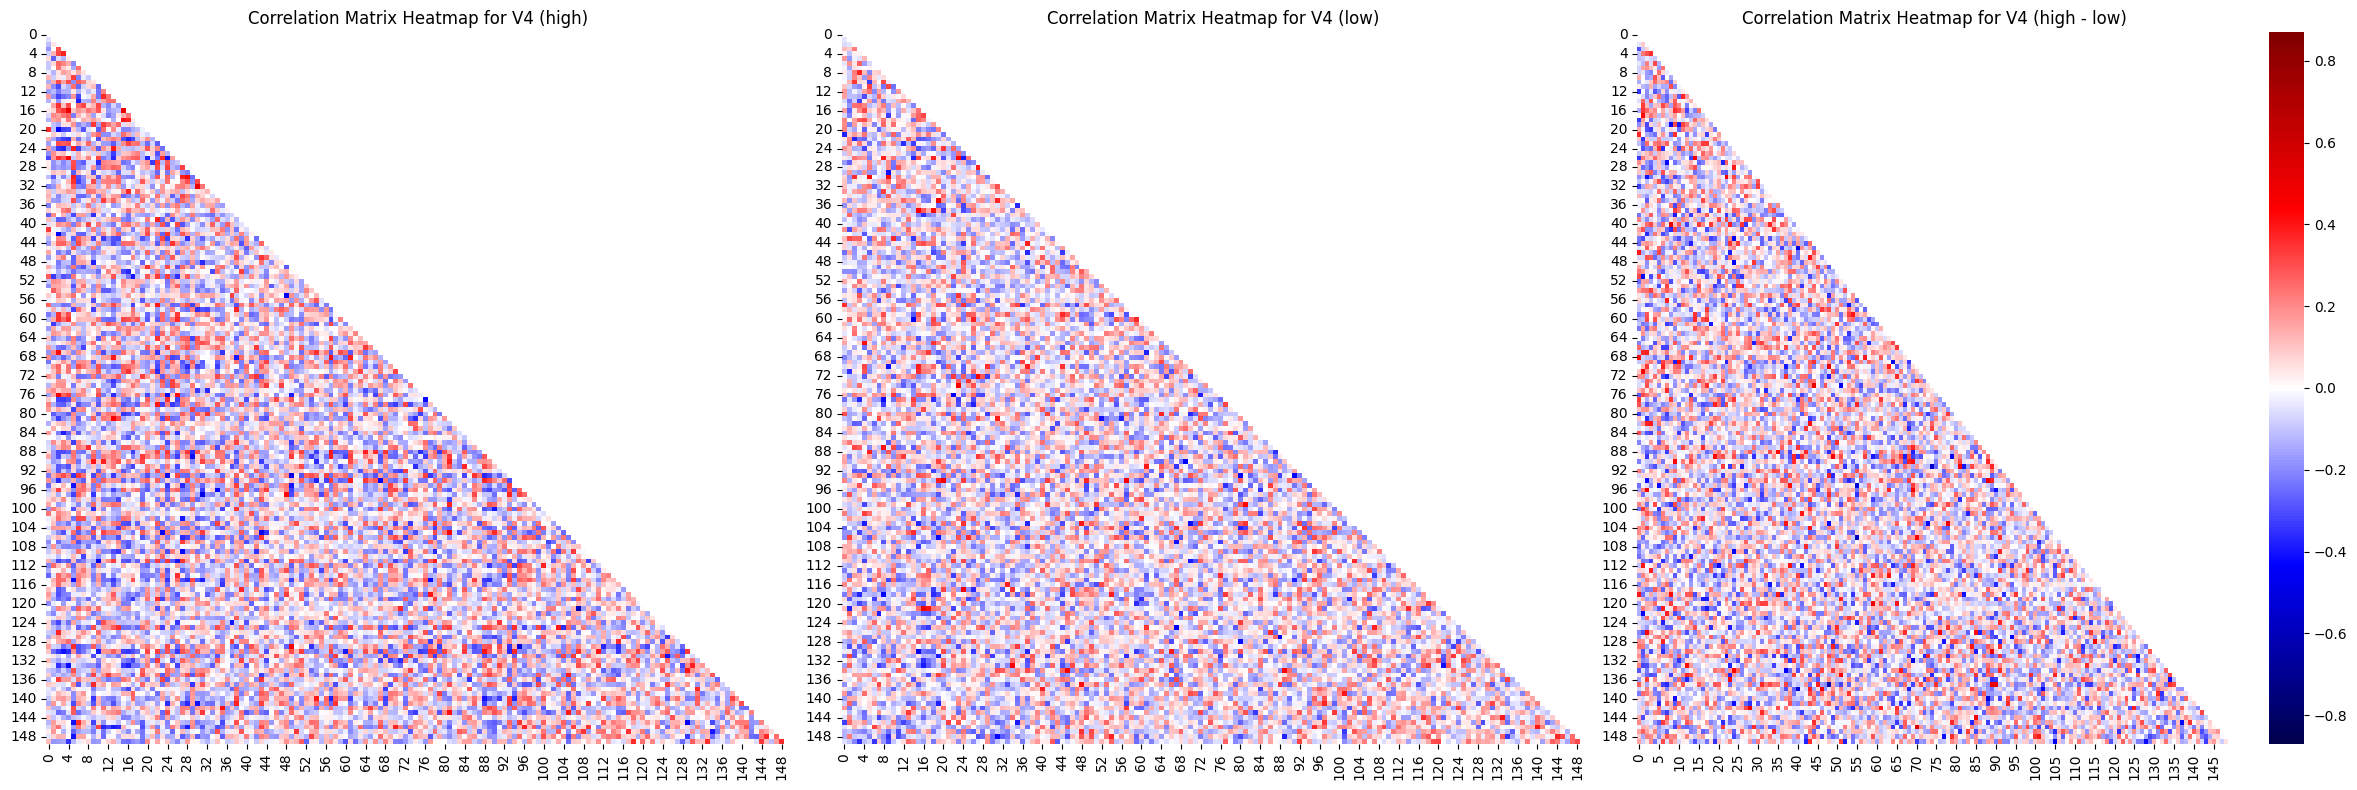

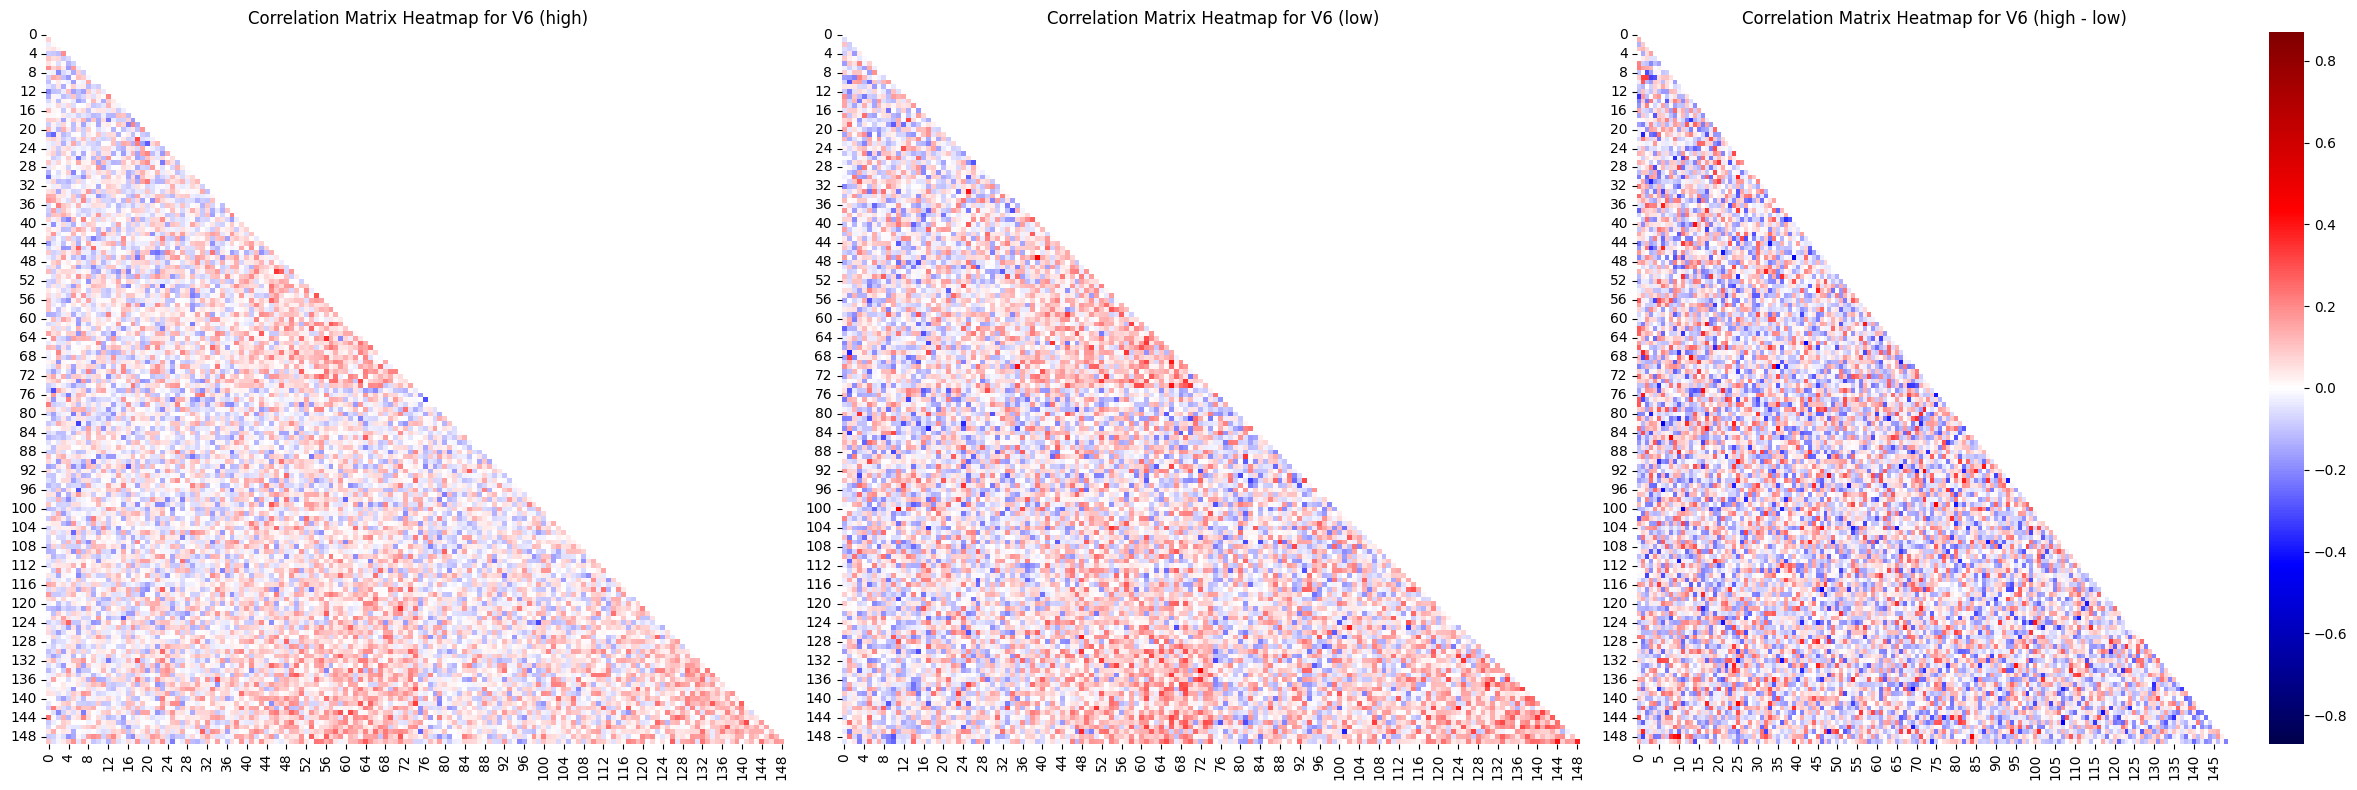

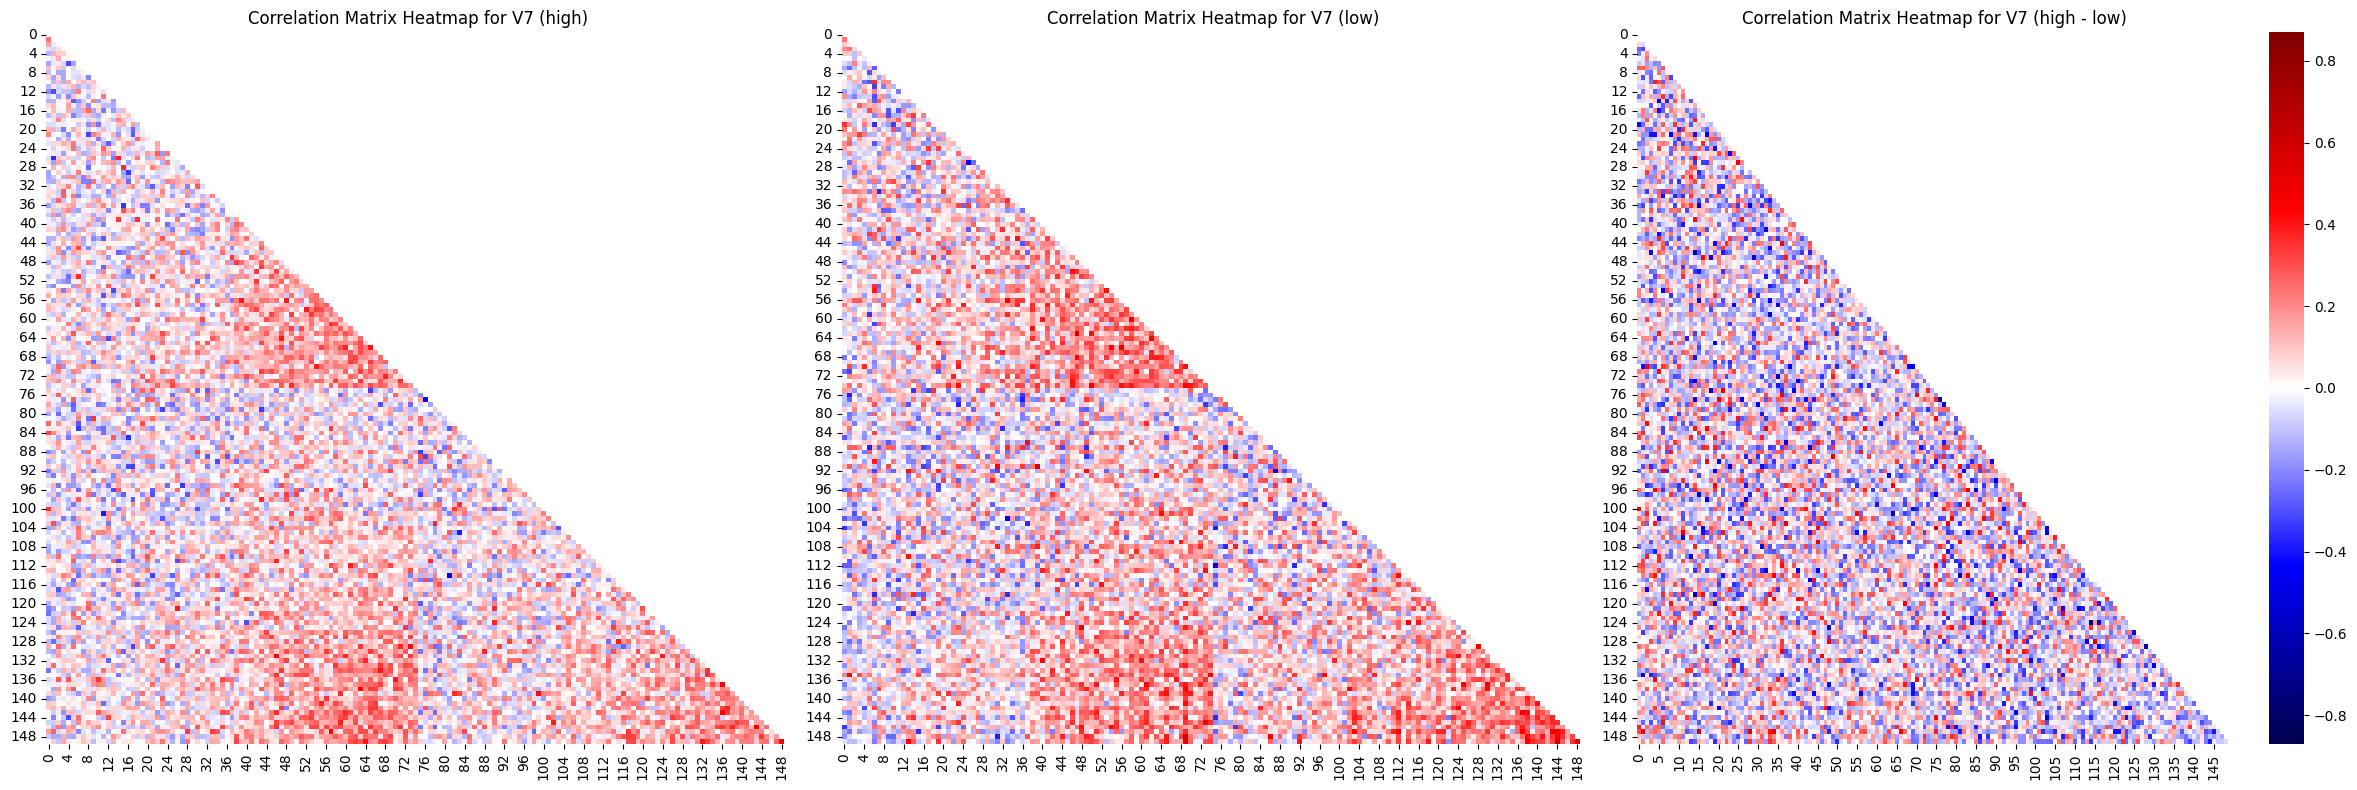

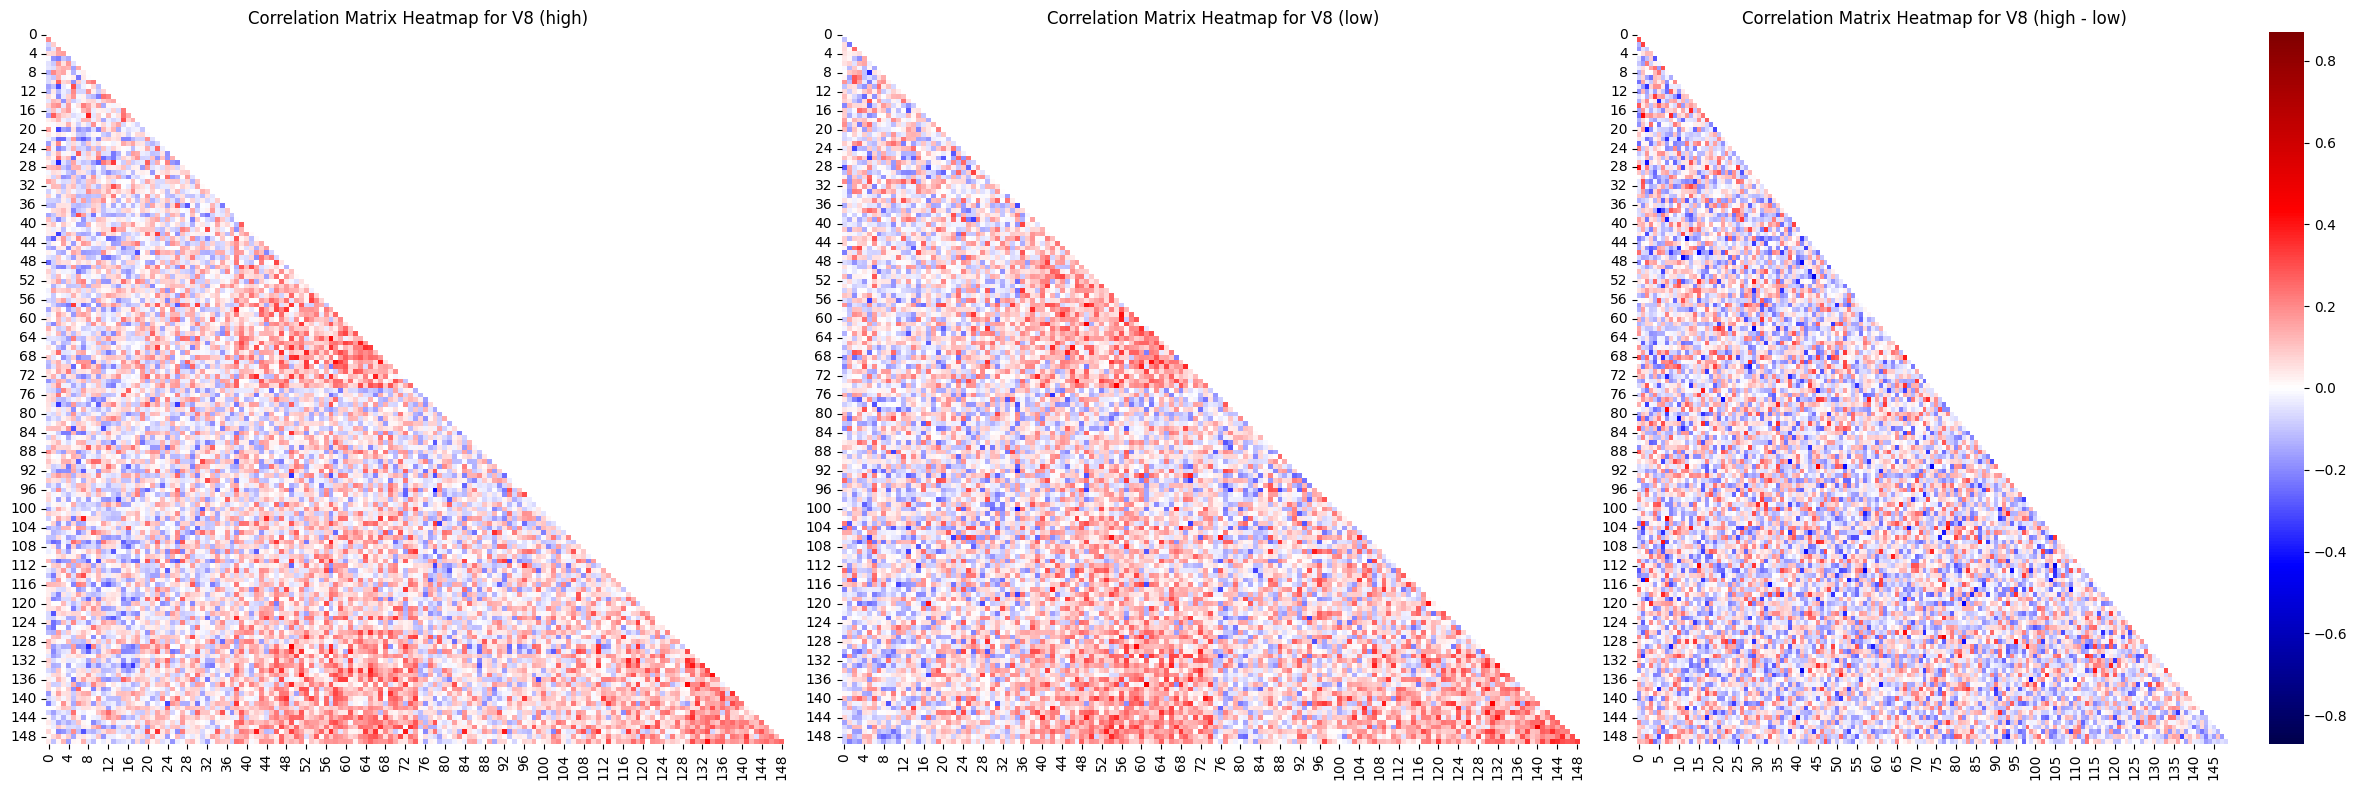

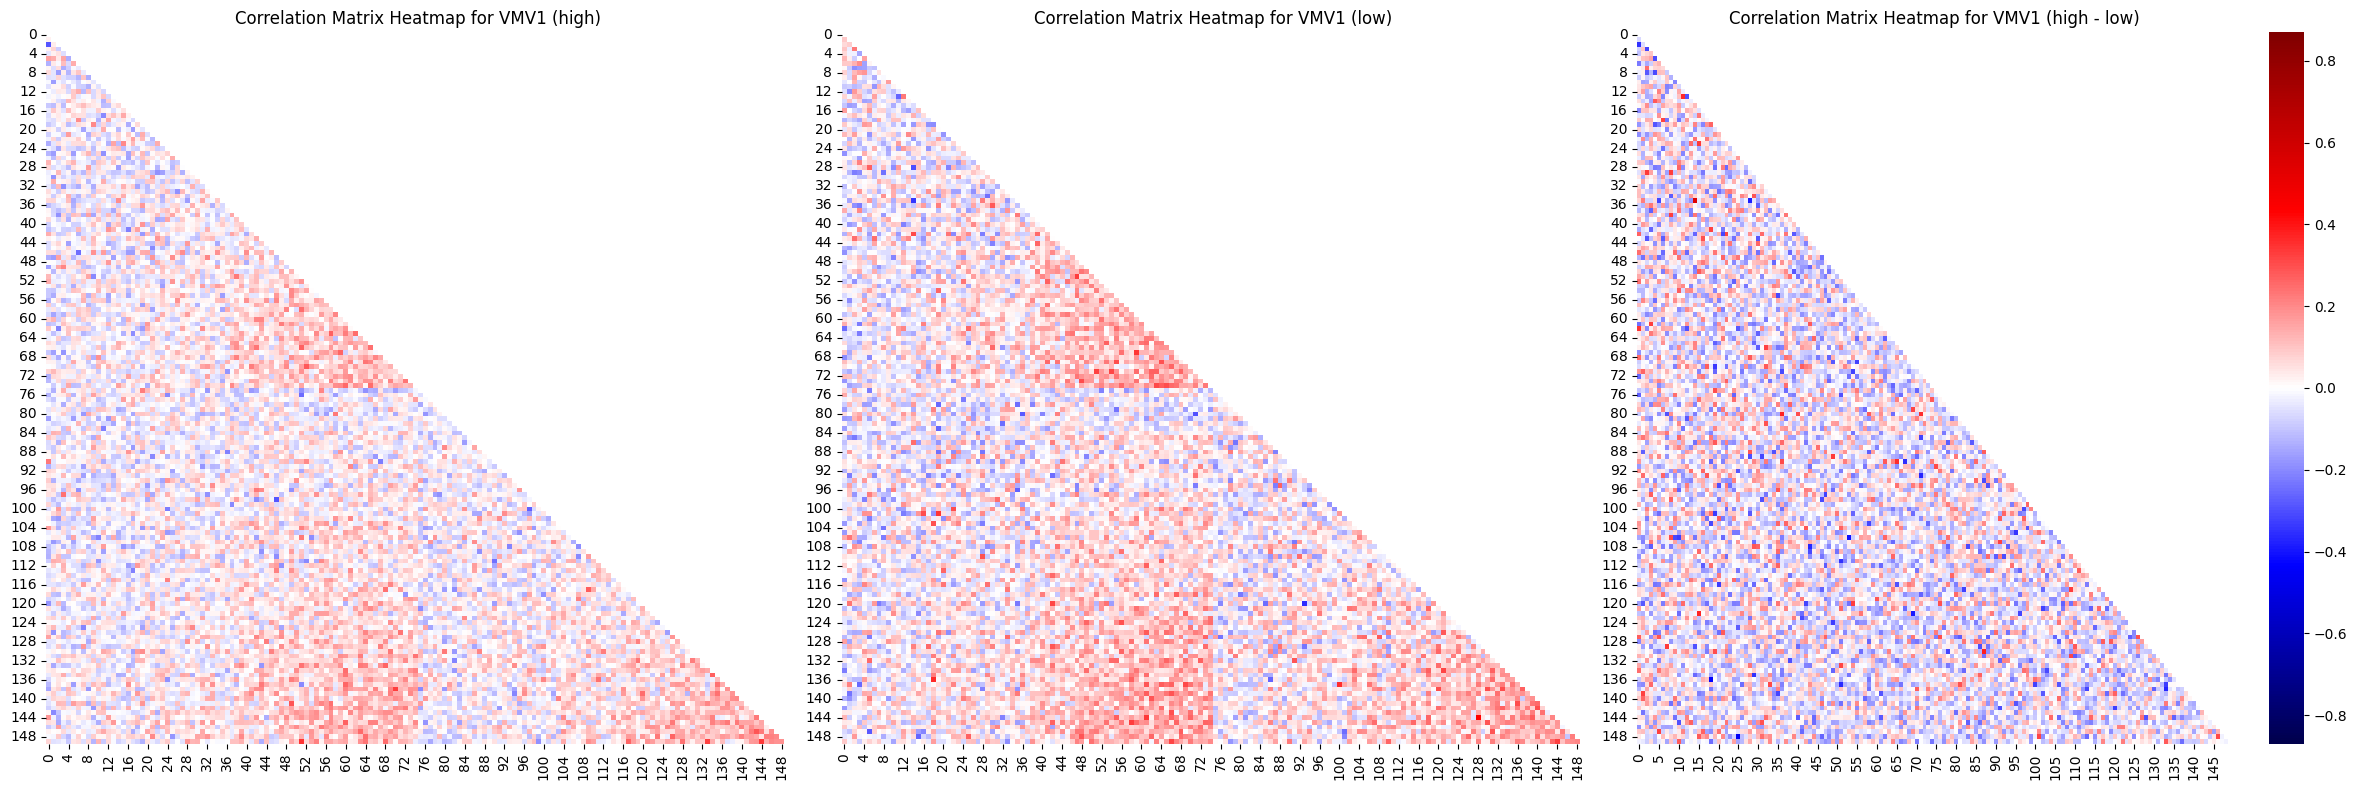

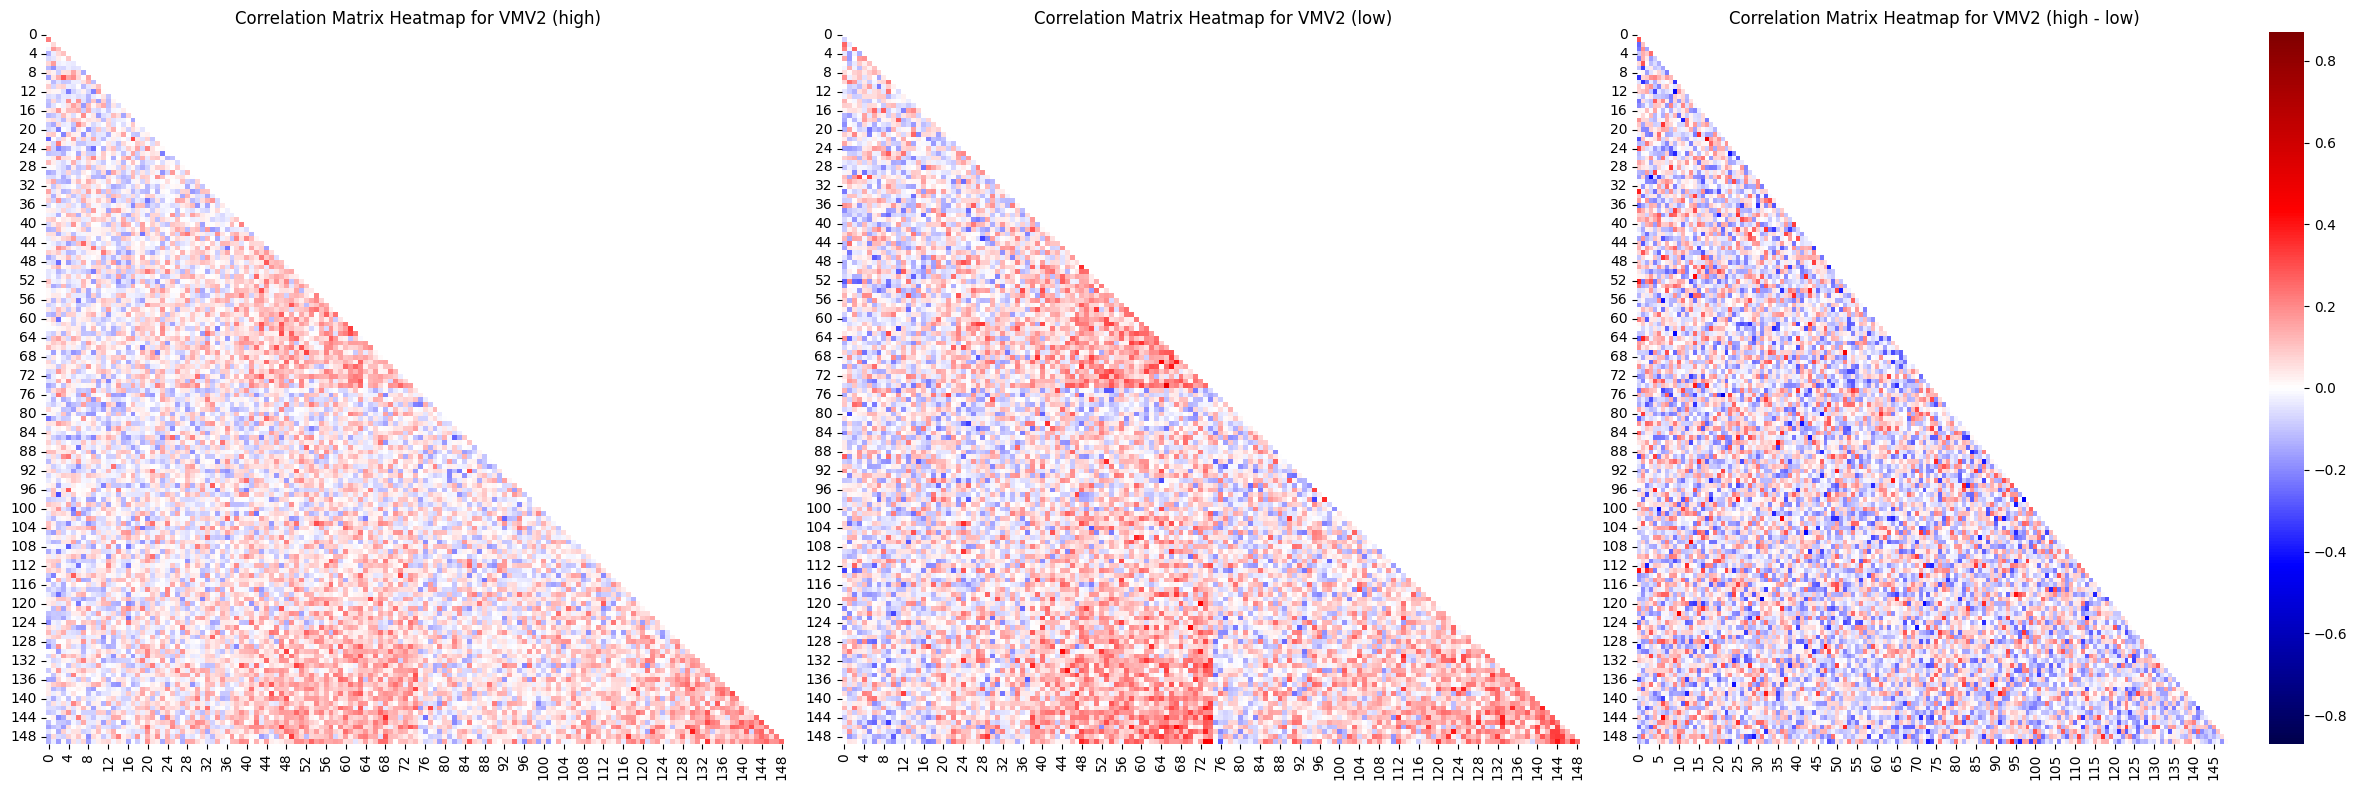

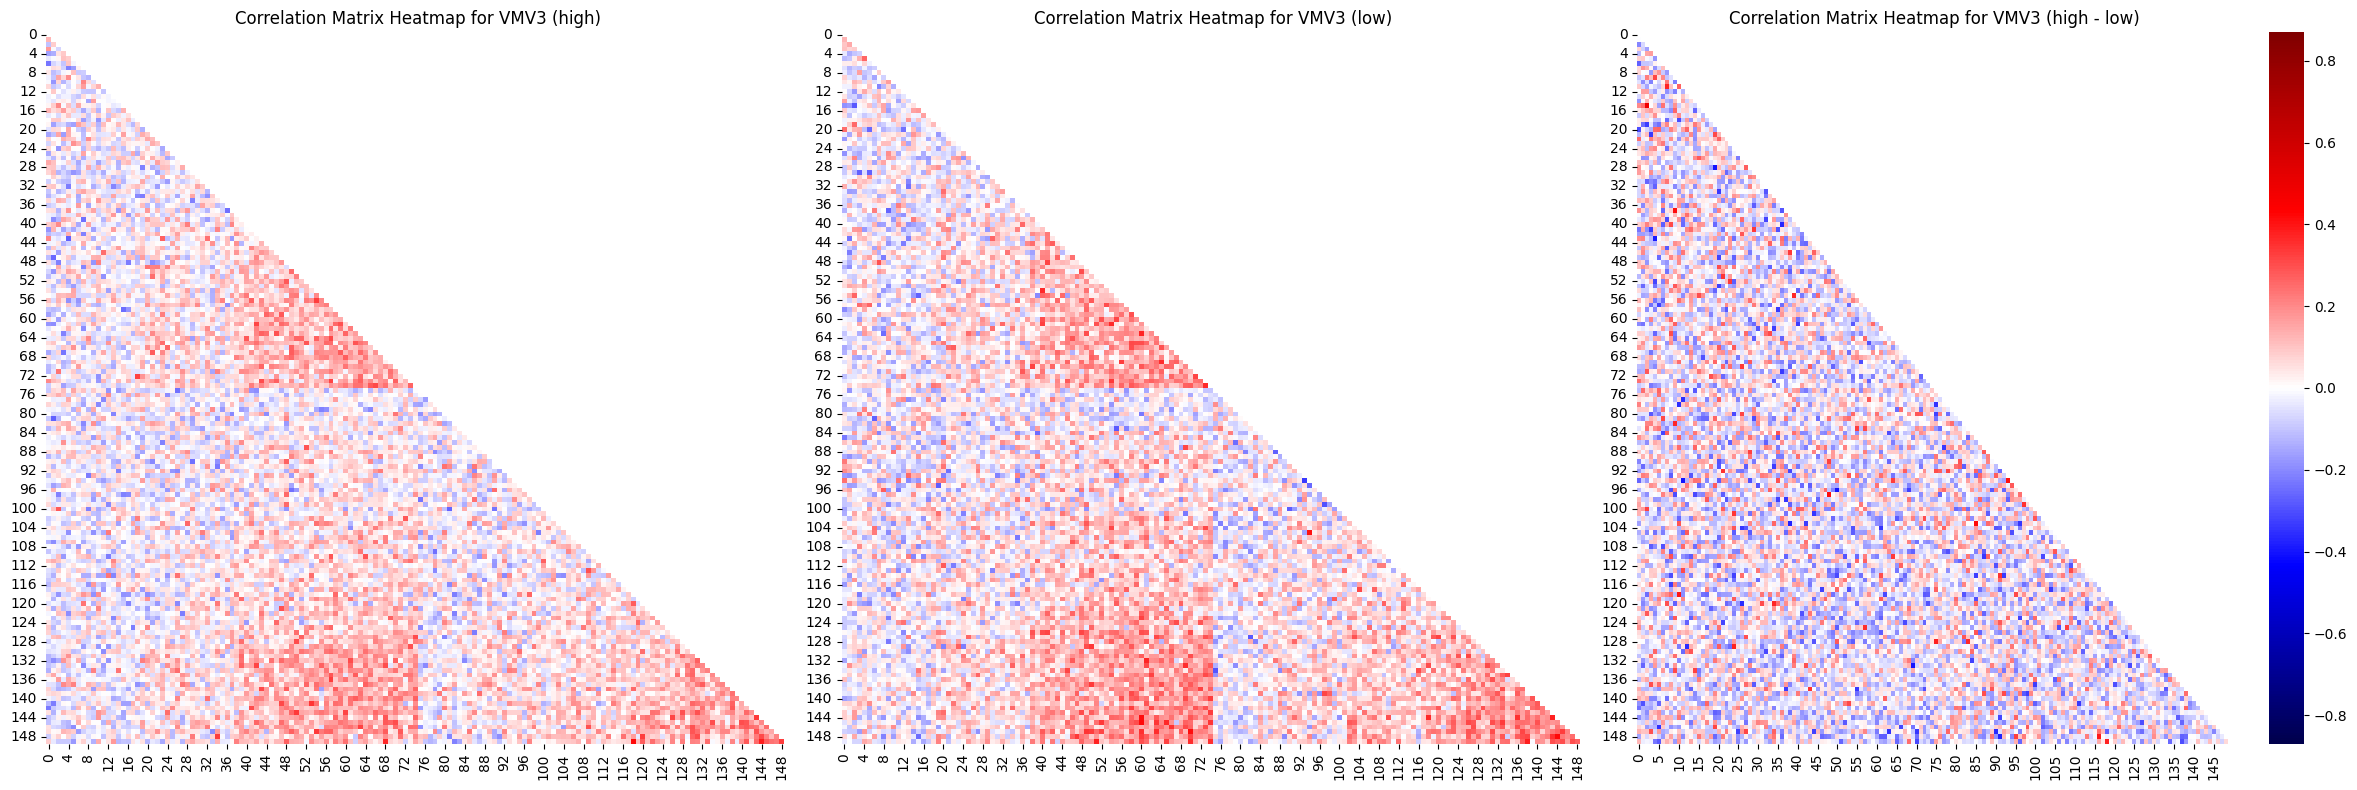

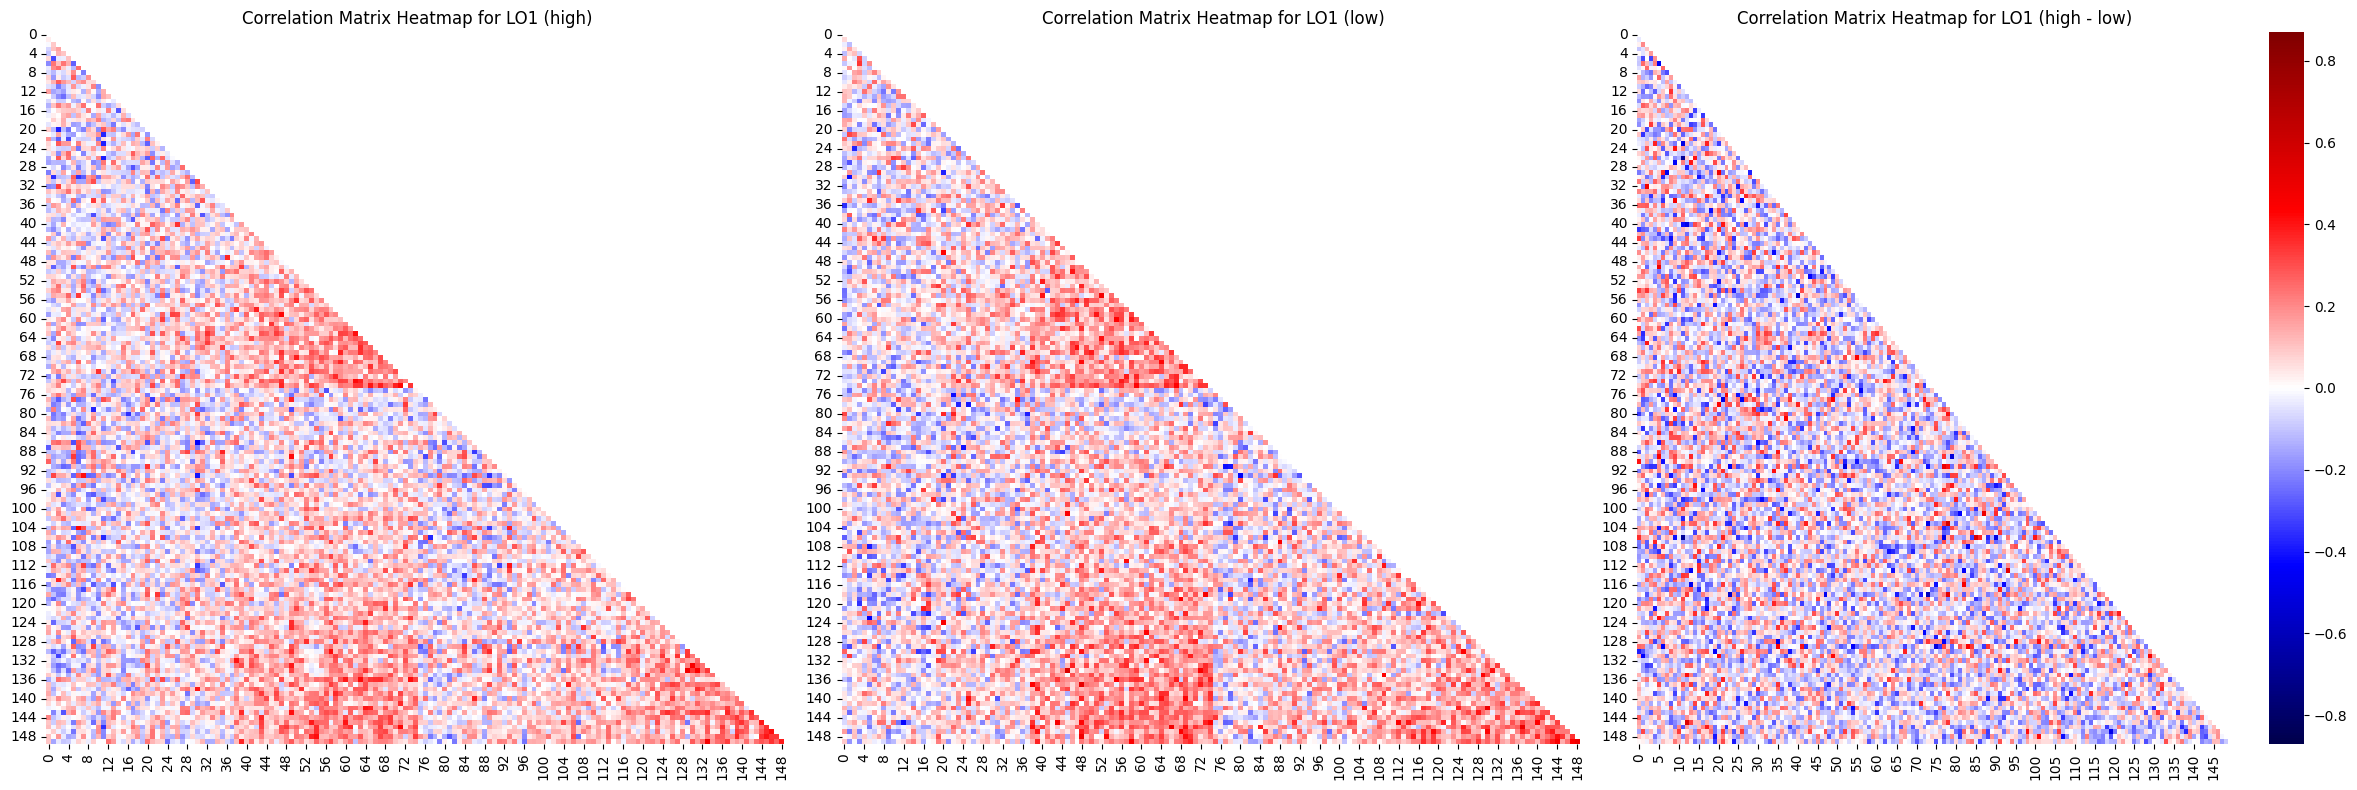

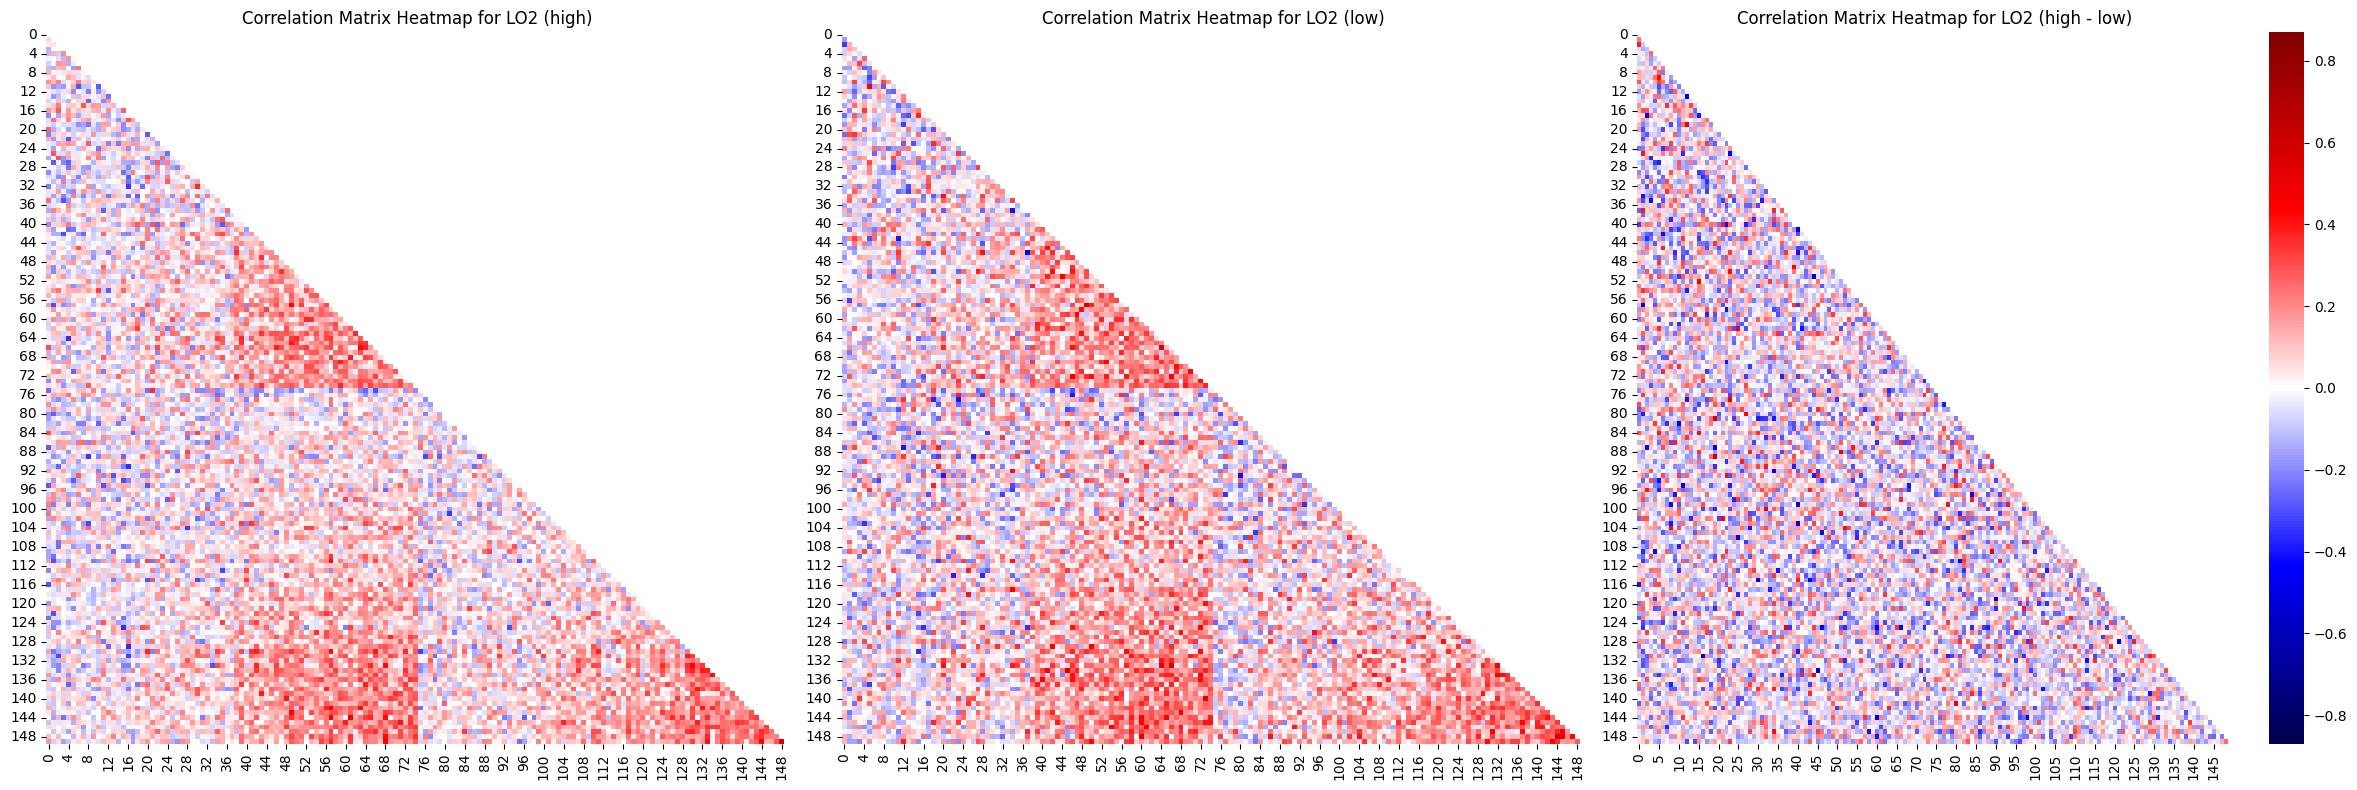

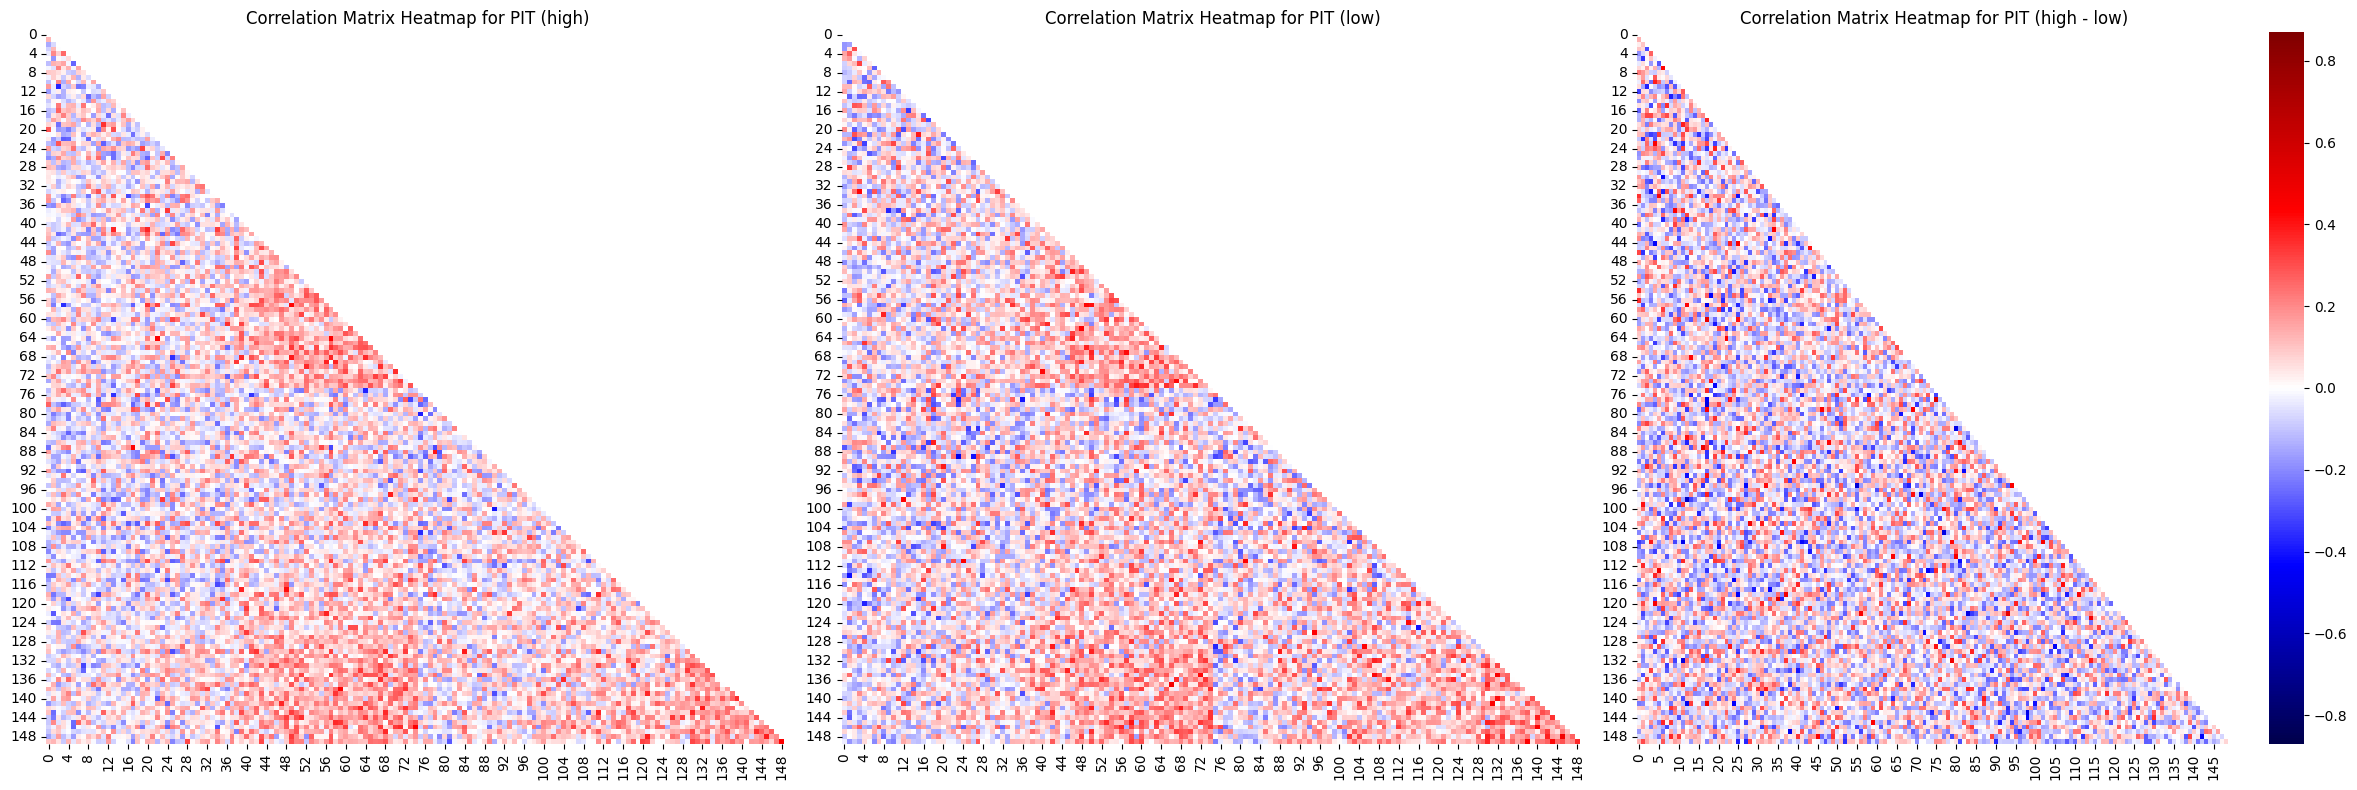

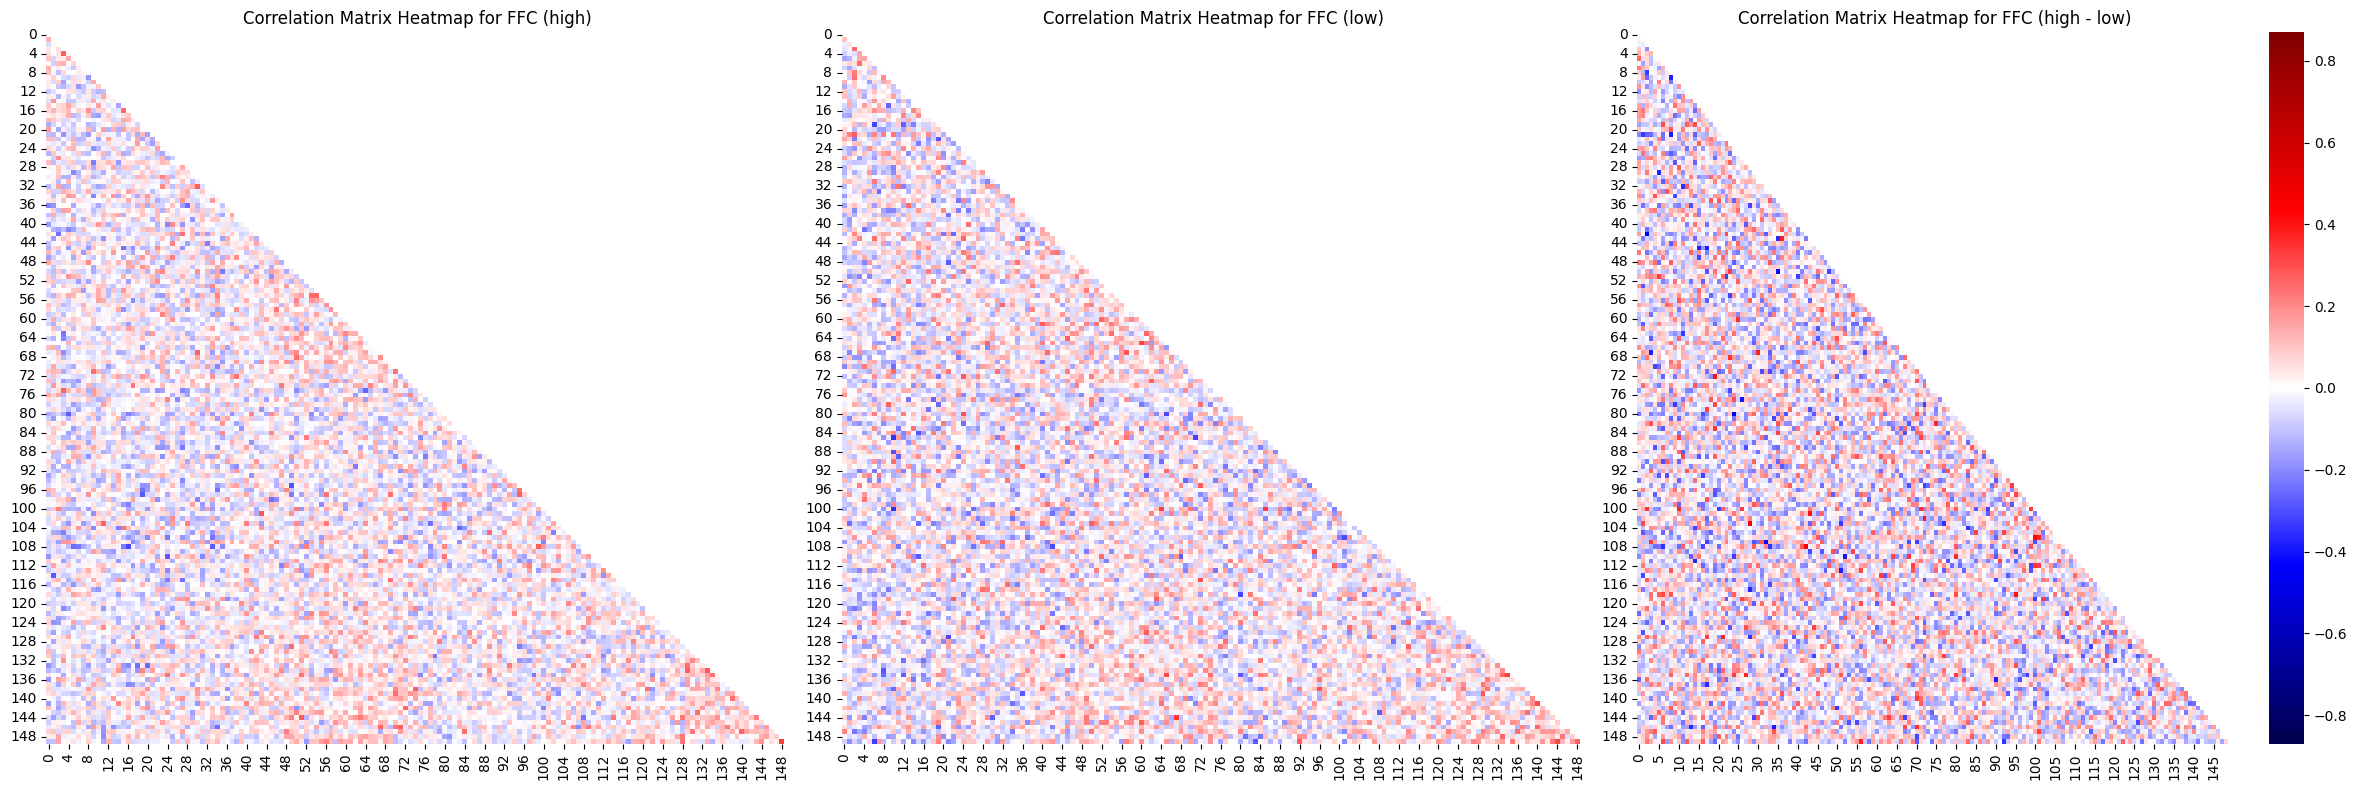

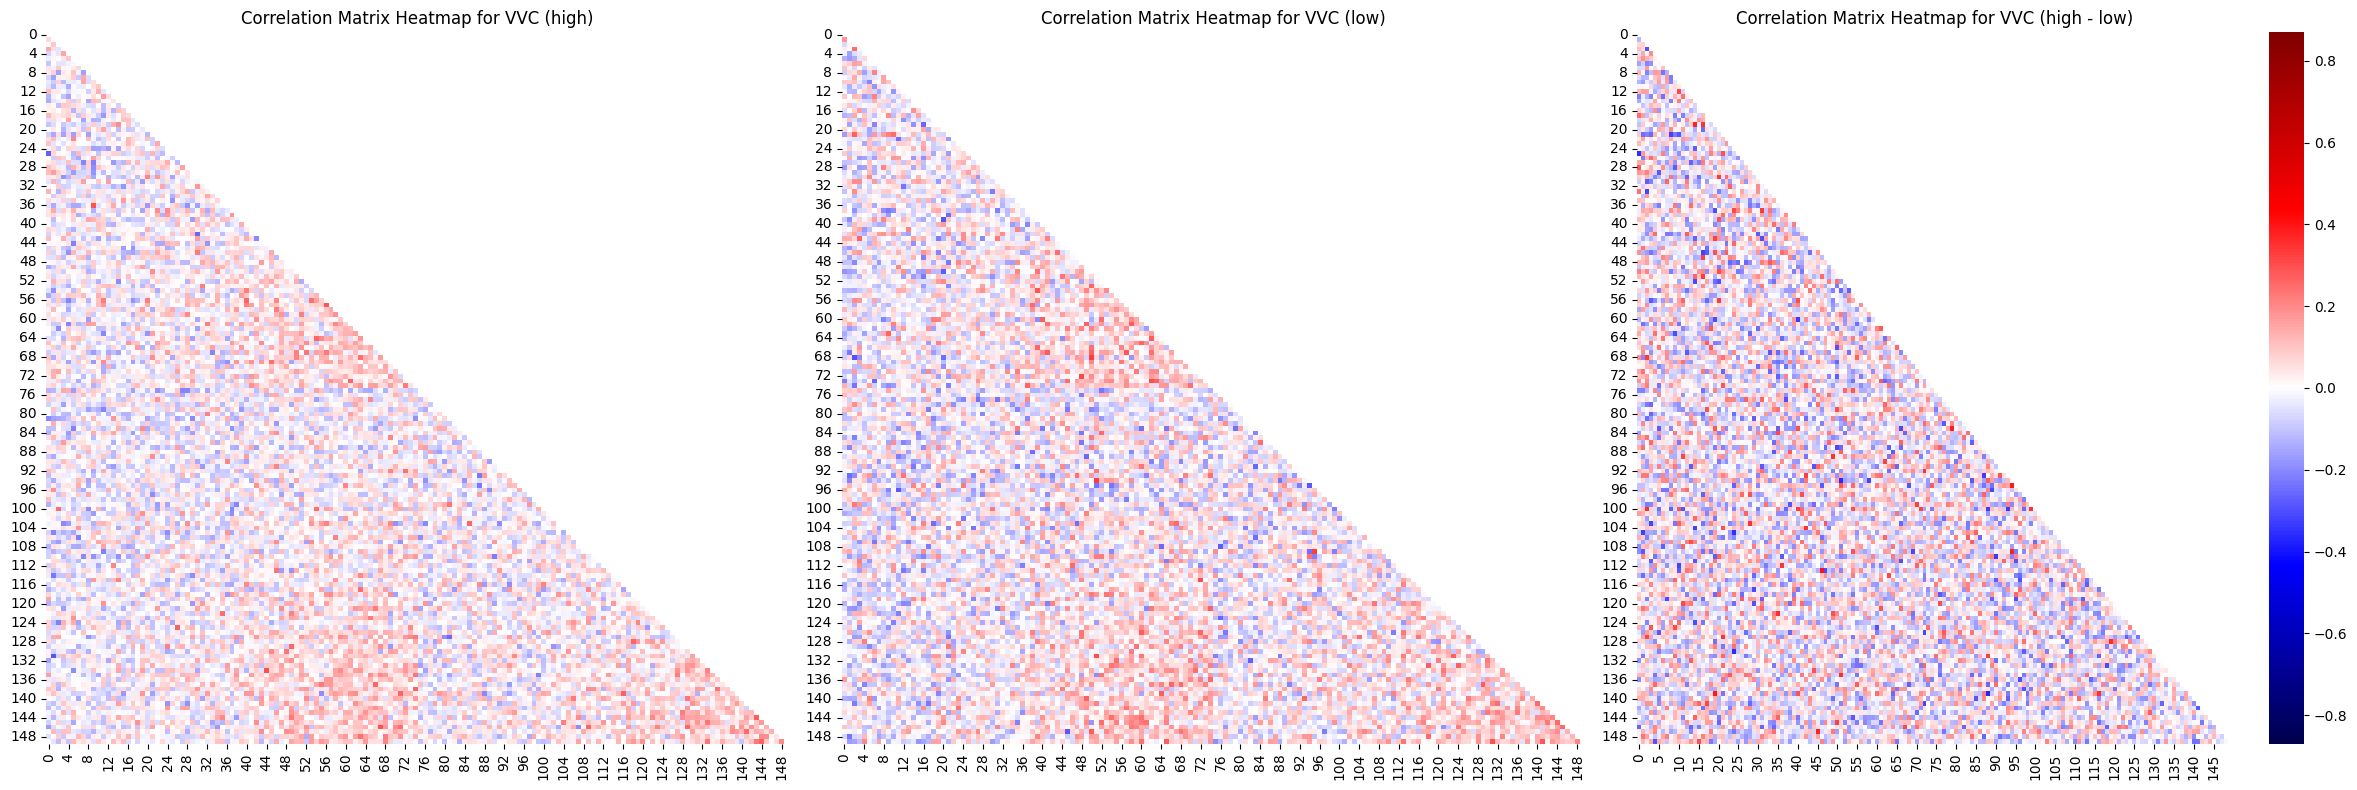

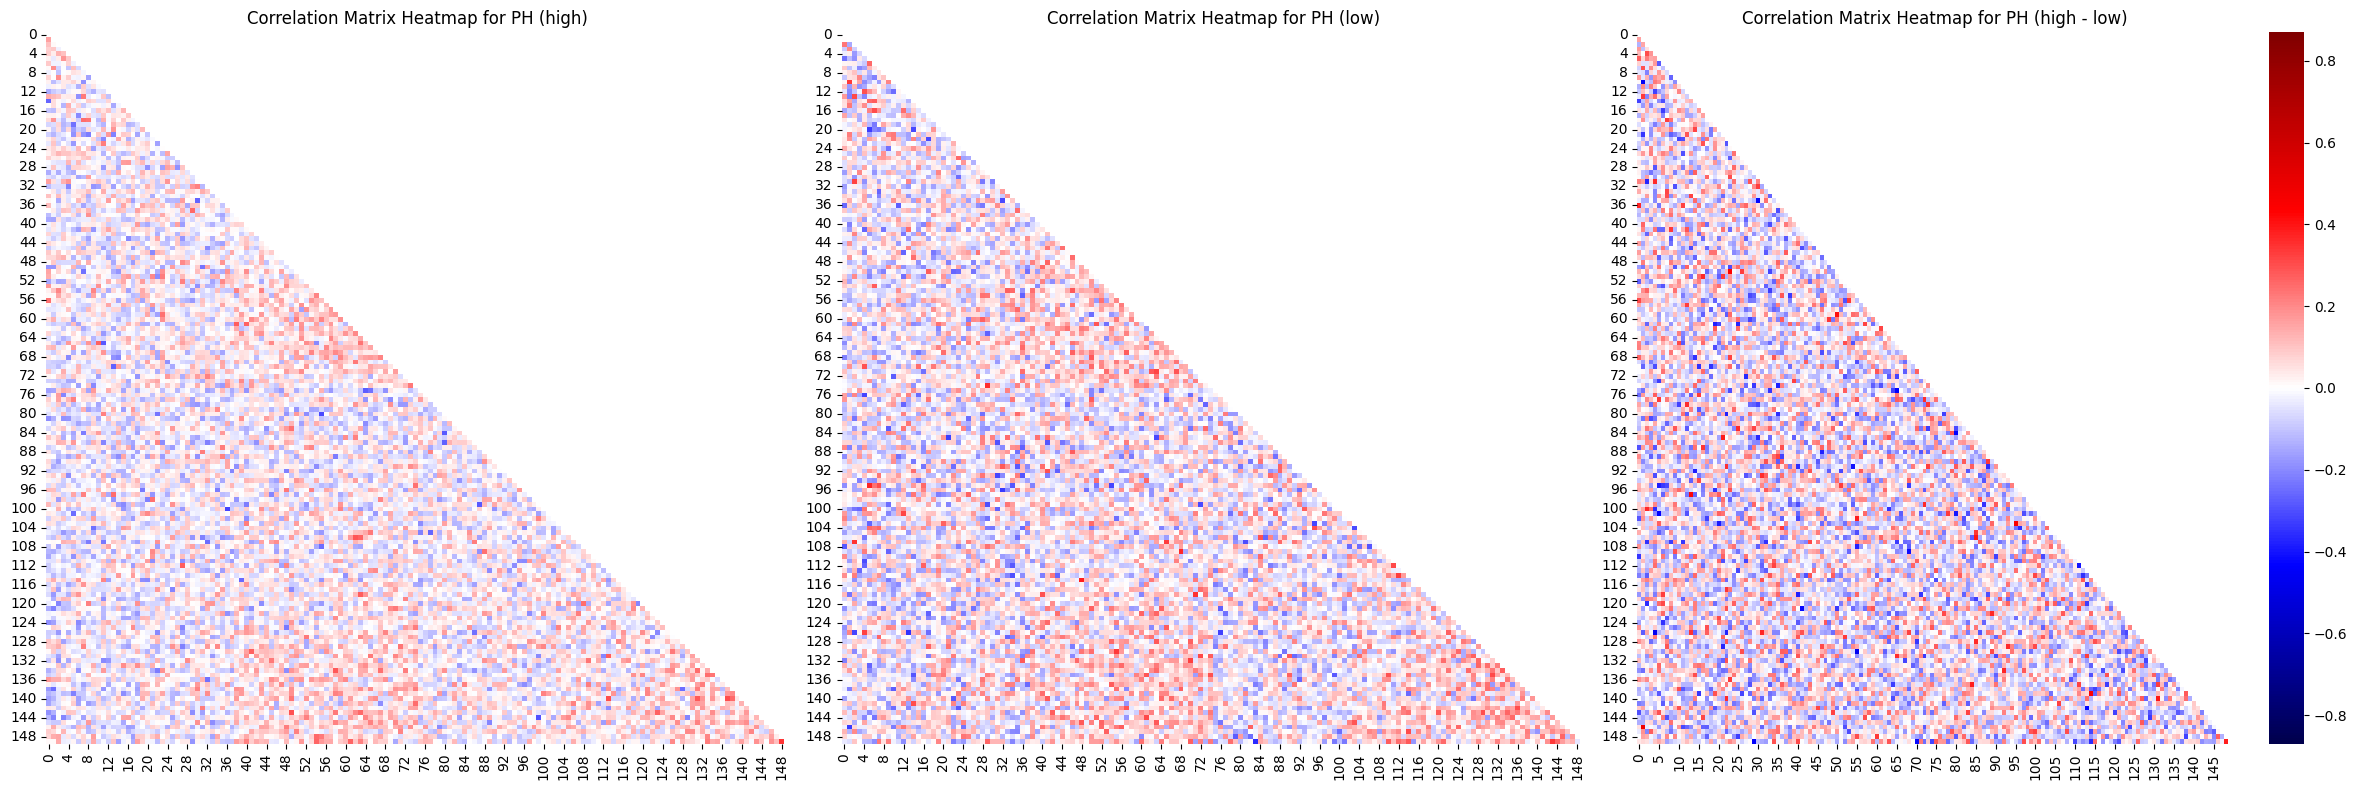

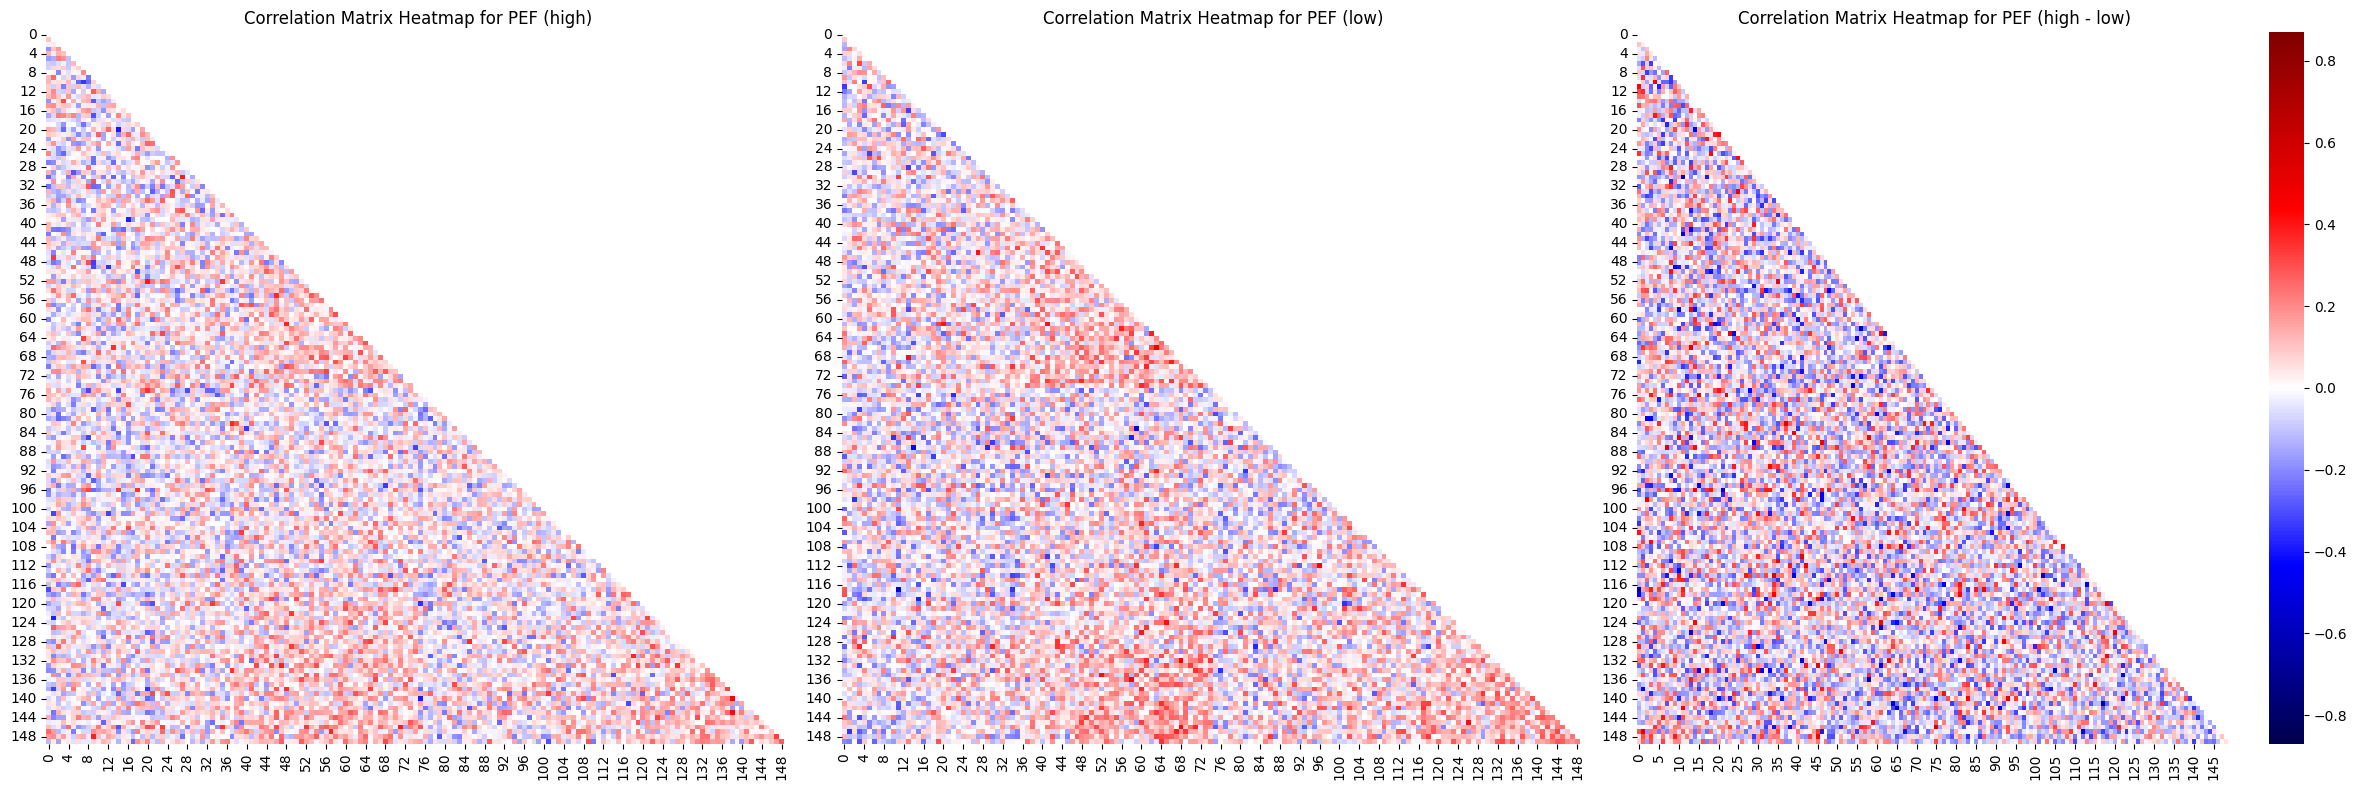

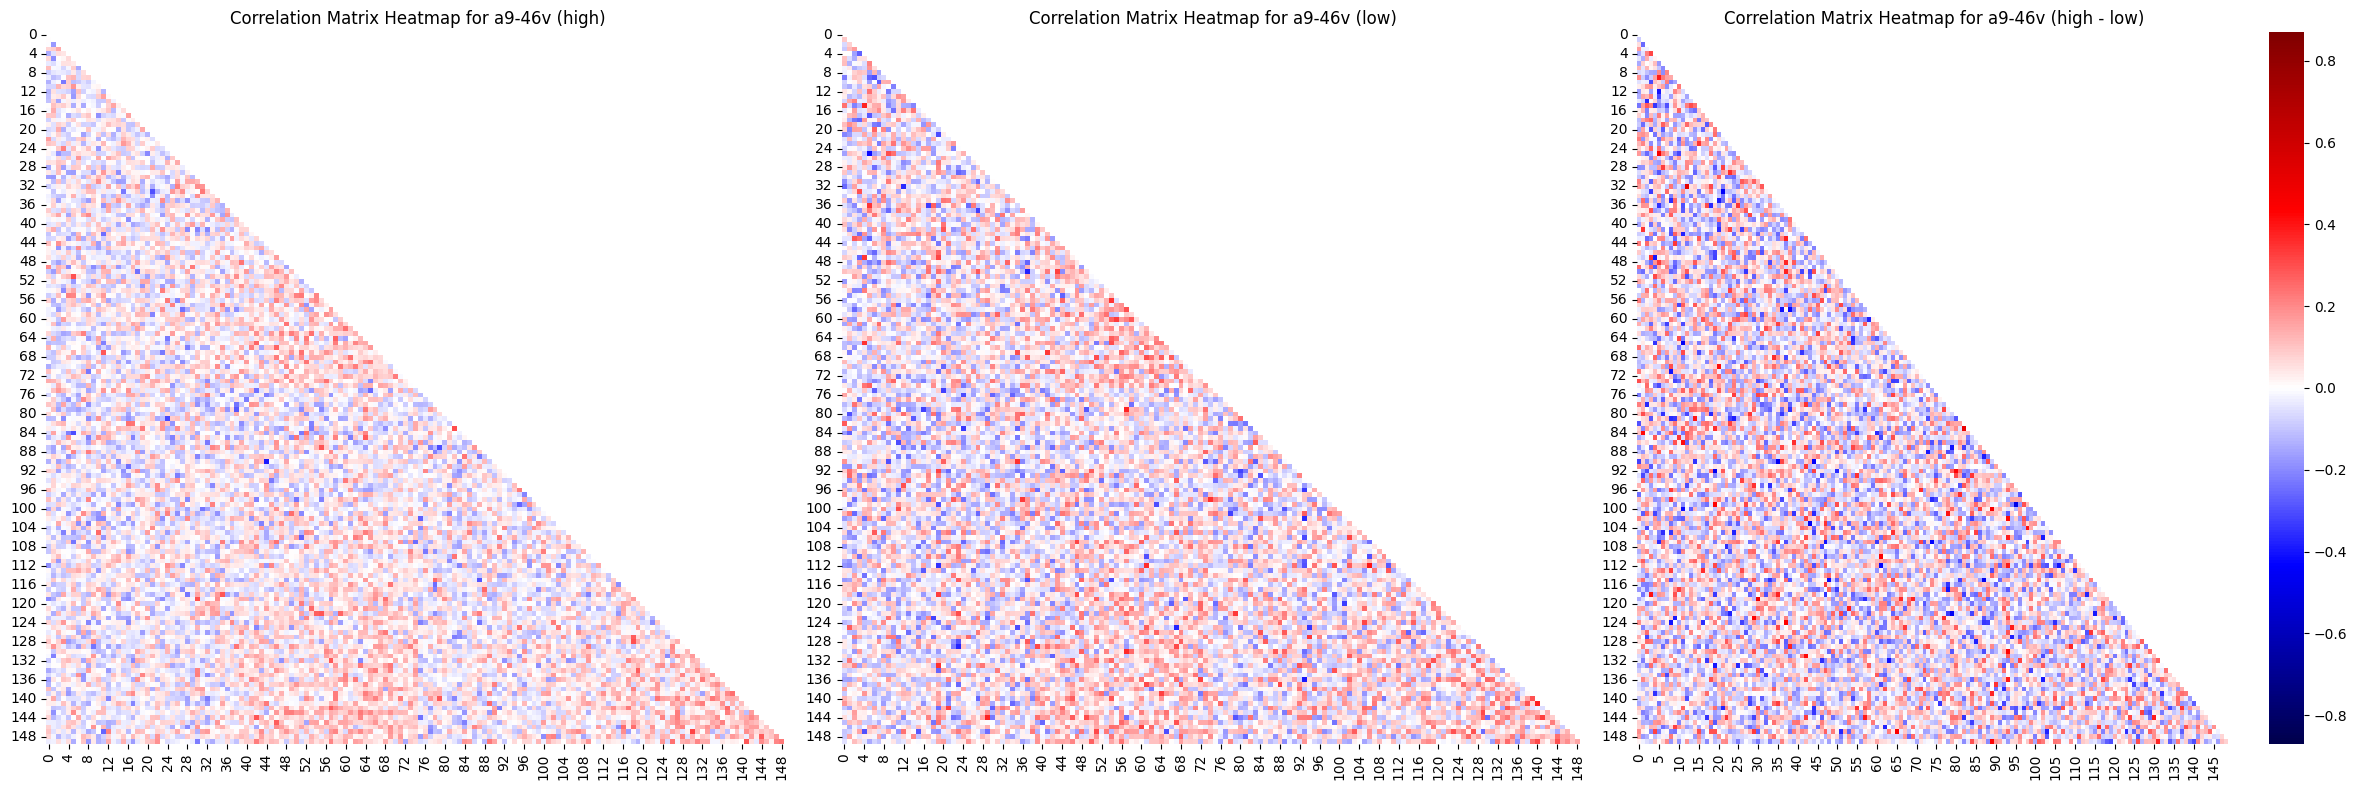

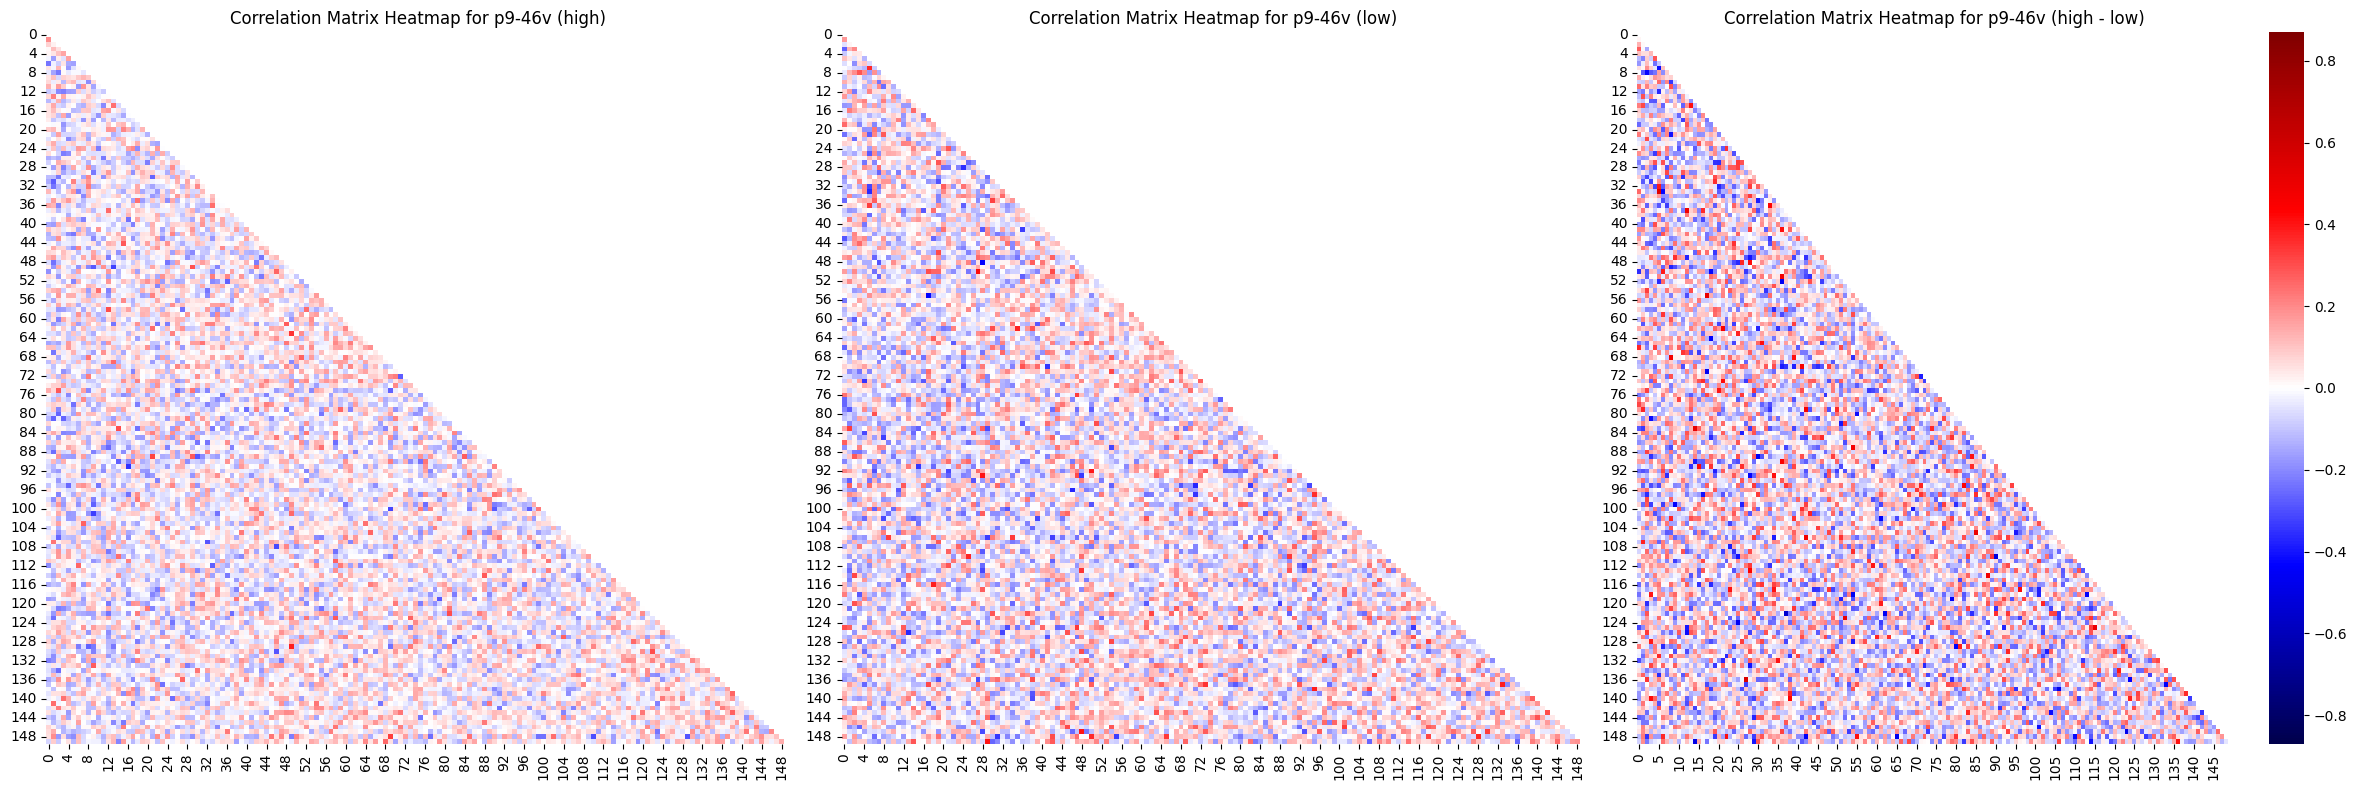

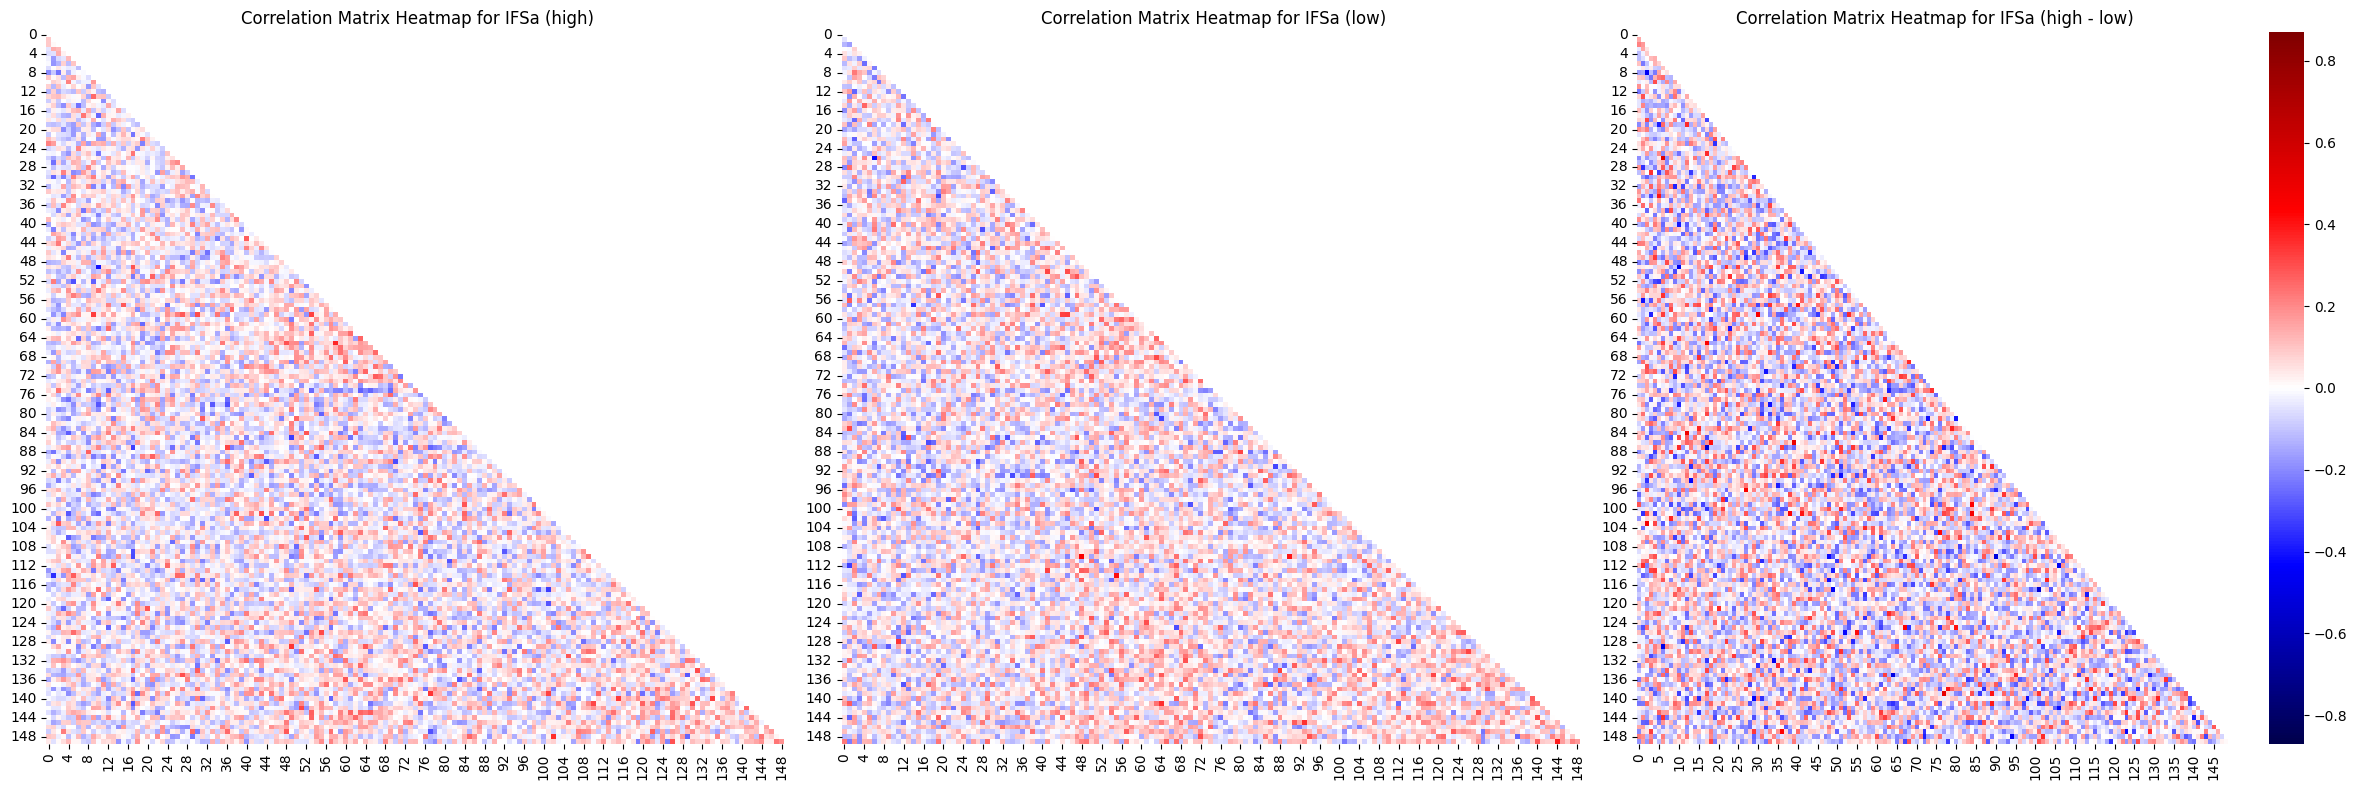

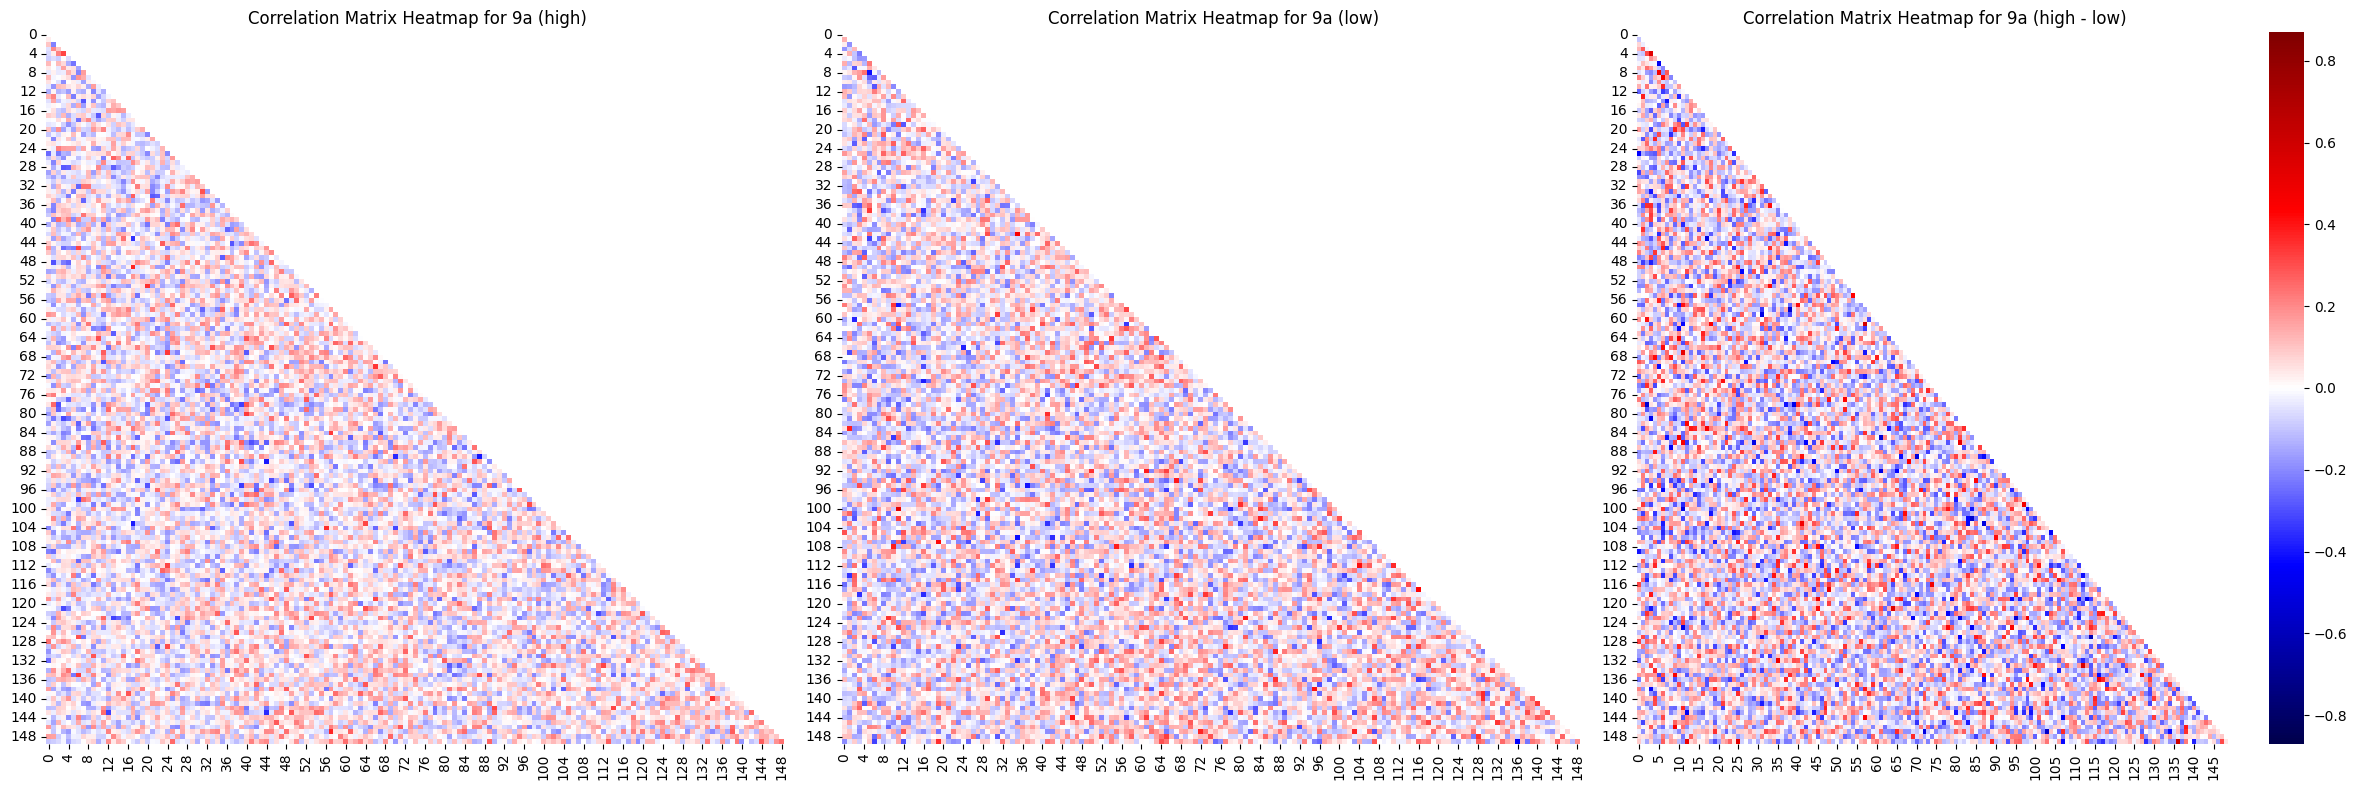

In [7]:
group_1 = 'high'
group_2 = 'low'
expertise_level_str_1 = subject_strs_dict[group_1][0]
expertise_level_str_2 = subject_strs_dict[group_2][0]

for ROI in ROIs:

        group_1_RDM = group_RDMs[group_1][ROI]
        group_2_RDM = group_RDMs[group_2][ROI]
        difference_RDM = group_1_RDM - group_2_RDM

        mask = np.triu(np.ones_like(difference_RDM, dtype=bool))

        # Create a figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))

        vmin = -0.87
        vmax = 0.87

        # Plot for group 1
        sns.heatmap(group_1_RDM, mask=mask, annot=False, cmap='seismic', vmin=vmin, vmax=vmax, ax=axes[0], cbar=False)
        axes[0].set_title(f'Correlation Matrix Heatmap for {ROI} ({expertise_level_str_1})')

        # Plot for group 2
        sns.heatmap(group_2_RDM, mask=mask, annot=False, cmap='seismic', vmin=vmin, vmax=vmax, ax=axes[1], cbar=False)
        axes[1].set_title(f'Correlation Matrix Heatmap for {ROI} ({expertise_level_str_2})')

        # Plot for the difference
        sns.heatmap(difference_RDM, mask=mask, annot=False, cmap='seismic', vmin=vmin, vmax=vmax, ax=axes[2])
        axes[2].set_title(f'Correlation Matrix Heatmap for {ROI} ({expertise_level_str_1} - {expertise_level_str_2})')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()



### Sanity tests for RDM heatmaps

In [8]:
individual_RDMs = {}

for group in expertise_groups:
    individual_RDMs[group] = {}
    expertise_level_str = subject_strs_dict[group][0]
    subject_strs        = subject_strs_dict[group][1]

    for subject_str in subject_strs:
        individual_RDMs[group][subject_str] = {}
        stim_ids_file_name = Path("E:/Decoding/fmri-preprocessing/img_bold_arrays") / f"sub_{subject_str}" / f"corr_matrices_avg_dups_2" / "stim_ids.npy"
        stim_id_data = np.load(stim_ids_file_name, allow_pickle=True)
        individual_RDMs[group][subject_str]["stim_ids"] = stim_id_data
        
        for ROI in ROIs:
            roi_path = Path("E:/Decoding/fmri-preprocessing/img_bold_arrays") / f"sub_{subject_str}" / f"corr_matrices_avg_dups_2" / "ROIs" / ROI

            correlation_file_name = roi_path / "correlation_matrix.npy"
            sub_roi_data = np.load(correlation_file_name, allow_pickle=True)
            individual_RDMs[group][subject_str][ROI] = sub_roi_data

In [9]:
test_col = 12
test_avgs = {}

for group_name, group in individual_RDMs.items():
    print(f"================ {group_name.upper()} Group ================")
    test_avgs[group_name] = []
    for ROI in ROIs:
        print(f"----- ROI: {ROI.upper()} -----")

        for participant_num, participant_data in group.items():
            RDM = participant_data[ROI]

            mask = np.triu(np.ones_like(RDM, dtype=bool))

            masked_RDM = RDM * mask

            column_avg = np.sum(np.abs(masked_RDM[:, 12]) ) # Sum of the 13th column (index 12)
            test_avgs[group_name].append(column_avg)

            # plt.figure(figsize=(12, 10))
            # sns.heatmap(RDM, mask=mask, annot=False, cmap='seismic', vmin=-1, vmax=1)
            # plt.title(f'Correlation Matrix Heatmap for {ROI} ({expertise_level_str})')
            # plt.savefig(f'correlation_matrices/high/correlation_matrix_heatmap_{ROI}_{expertise_level_str}.png')
            # plt.show()

================ LOW Group ================
----- ROI: V1 -----
----- ROI: V2 -----
----- ROI: V3 -----
----- ROI: V3A -----
----- ROI: V3B -----
----- ROI: V3CD -----
----- ROI: V4 -----
----- ROI: V6 -----
----- ROI: V7 -----
----- ROI: V8 -----
----- ROI: VMV1 -----
----- ROI: VMV2 -----
----- ROI: VMV3 -----
----- ROI: LO1 -----
----- ROI: LO2 -----
----- ROI: PIT -----
----- ROI: FFC -----
----- ROI: VVC -----
----- ROI: PH -----
----- ROI: PEF -----
----- ROI: A9-46V -----
----- ROI: P9-46V -----
----- ROI: IFSA -----
----- ROI: 9A -----
================ HIGH Group ================
----- ROI: V1 -----
----- ROI: V2 -----
----- ROI: V3 -----
----- ROI: V3A -----
----- ROI: V3B -----
----- ROI: V3CD -----
----- ROI: V4 -----
----- ROI: V6 -----
----- ROI: V7 -----
----- ROI: V8 -----
----- ROI: VMV1 -----
----- ROI: VMV2 -----
----- ROI: VMV3 -----
----- ROI: LO1 -----
----- ROI: LO2 -----
----- ROI: PIT -----
----- ROI: FFC -----
----- ROI: VVC -----
----- ROI: PH -----
----- ROI:

================ LOW Group ================
----- ROI: V1 -----


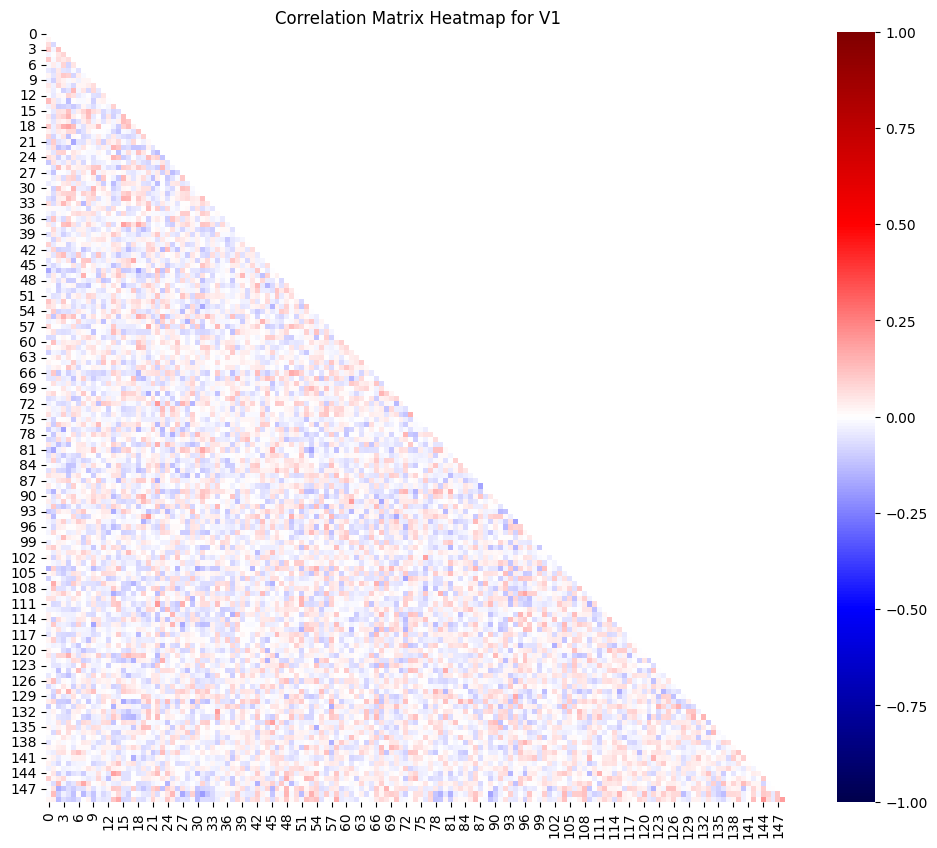


Top 8 row/column pairs for V1:
    Row/col: (144, 149),  stimulus IDs: (230, 184), Image Locations: 173.Orange_crowned_Warbler_0.png, 167.Hooded_Warbler_4.png
    Row/col: (22, 111),  stimulus IDs: (82, 153), Image Locations: 124.Le_Conte_Sparrow_2.png, 161.Blue_winged_Warbler_3.png
    Row/col: (20, 94),  stimulus IDs: (84, 164), Image Locations: 124.Le_Conte_Sparrow_4.png, 162.Canada_Warbler_4.png
    Row/col: (22, 72),  stimulus IDs: (82, 51), Image Locations: 124.Le_Conte_Sparrow_2.png, 119.Field_Sparrow_1.png
    Row/col: (34, 132),  stimulus IDs: (1, 223), Image Locations: 113.Baird_Sparrow_1.png, 172.Nashville_Warbler_3.png
    Row/col: (148, 149),  stimulus IDs: (202, 184), Image Locations: 169.Magnolia_Warbler_2.png, 167.Hooded_Warbler_4.png
    Row/col: (61, 91),  stimulus IDs: (22, 173), Image Locations: 116.Chipping_Sparrow_2.png, 163.Cape_May_Warbler_3.png
    Row/col: (13, 144),  stimulus IDs: (34, 230), Image Locations: 117.Clay_colored_Sparrow_4.png, 173.Orange_crowned

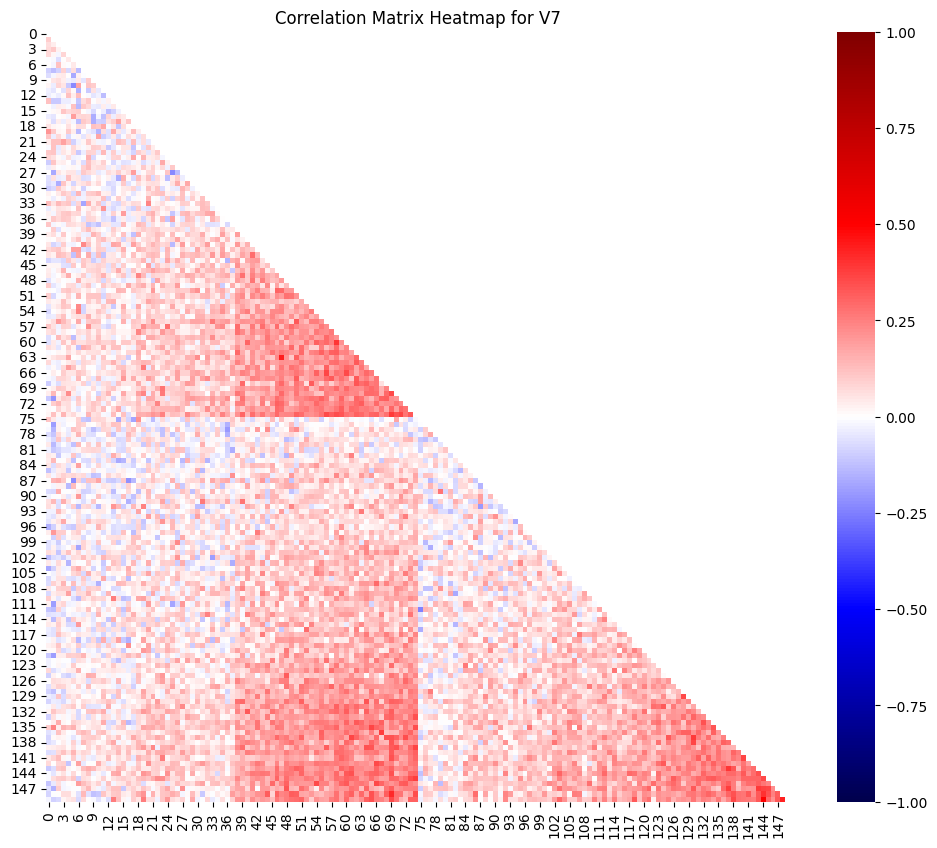


Top 8 row/column pairs for V7:
    Row/col: (144, 149),  stimulus IDs: (230, 184), Image Locations: 173.Orange_crowned_Warbler_0.png, 167.Hooded_Warbler_4.png
    Row/col: (47, 63),  stimulus IDs: (102, 14), Image Locations: 126.Nelson_Sharp_tailed_Sparrow_2.png, 115.Brewer_Sparrow_4.png
    Row/col: (148, 149),  stimulus IDs: (202, 184), Image Locations: 169.Magnolia_Warbler_2.png, 167.Hooded_Warbler_4.png
    Row/col: (69, 148),  stimulus IDs: (33, 202), Image Locations: 117.Clay_colored_Sparrow_3.png, 169.Magnolia_Warbler_2.png
    Row/col: (144, 148),  stimulus IDs: (230, 202), Image Locations: 173.Orange_crowned_Warbler_0.png, 169.Magnolia_Warbler_2.png
    Row/col: (58, 60),  stimulus IDs: (131, 30), Image Locations: 130.Tree_Sparrow_1.png, 117.Clay_colored_Sparrow_0.png
    Row/col: (137, 143),  stimulus IDs: (222, 251), Image Locations: 172.Nashville_Warbler_2.png, 175.Pine_Warbler_1.png
    Row/col: (130, 137),  stimulus IDs: (234, 222), Image Locations: 173.Orange_crowned_Wa

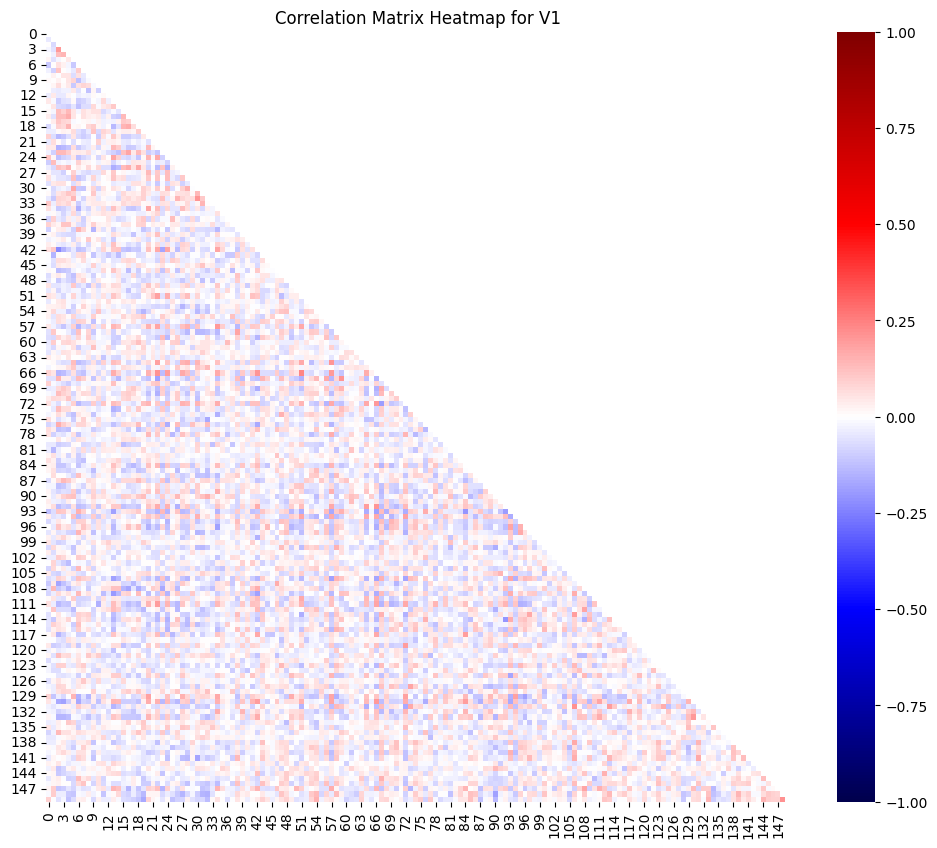


Top 8 row/column pairs for V1:
    Row/col: (51, 66),  stimulus IDs: (90, 10), Image Locations: 125.Lincoln_Sparrow_0.png, 115.Brewer_Sparrow_0.png
    Row/col: (106, 131),  stimulus IDs: (241, 231), Image Locations: 174.Palm_Warbler_1.png, 173.Orange_crowned_Warbler_1.png
    Row/col: (148, 149),  stimulus IDs: (202, 184), Image Locations: 169.Magnolia_Warbler_2.png, 167.Hooded_Warbler_4.png
    Row/col: (22, 66),  stimulus IDs: (82, 10), Image Locations: 124.Le_Conte_Sparrow_2.png, 115.Brewer_Sparrow_0.png
    Row/col: (42, 66),  stimulus IDs: (43, 10), Image Locations: 118.House_Sparrow_3.png, 115.Brewer_Sparrow_0.png
    Row/col: (66, 92),  stimulus IDs: (10, 171), Image Locations: 115.Brewer_Sparrow_0.png, 163.Cape_May_Warbler_1.png
    Row/col: (57, 64),  stimulus IDs: (133, 13), Image Locations: 130.Tree_Sparrow_3.png, 115.Brewer_Sparrow_3.png
    Row/col: (59, 67),  stimulus IDs: (122, 31), Image Locations: 129.Song_Sparrow_2.png, 117.Clay_colored_Sparrow_1.png

Bottom 8 row/c

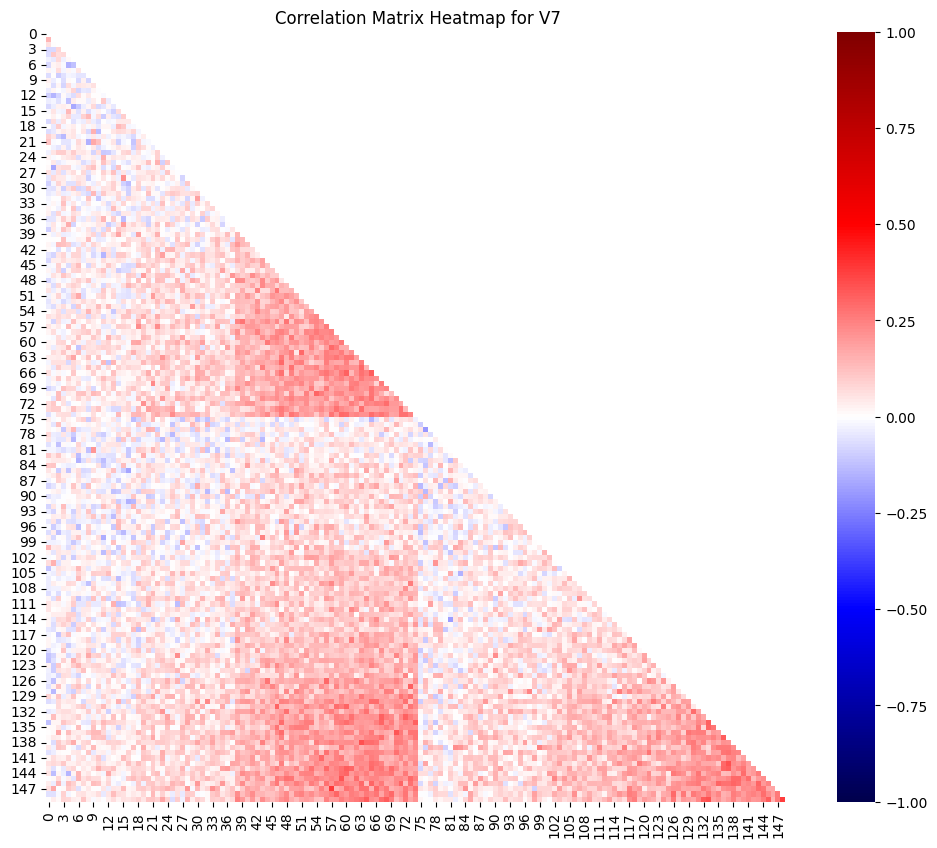


Top 8 row/column pairs for V7:
    Row/col: (57, 147),  stimulus IDs: (133, 272), Image Locations: 130.Tree_Sparrow_3.png, 179.Tennessee_Warbler_2.png
    Row/col: (148, 149),  stimulus IDs: (202, 184), Image Locations: 169.Magnolia_Warbler_2.png, 167.Hooded_Warbler_4.png
    Row/col: (133, 149),  stimulus IDs: (273, 184), Image Locations: 179.Tennessee_Warbler_3.png, 167.Hooded_Warbler_4.png
    Row/col: (137, 142),  stimulus IDs: (222, 221), Image Locations: 172.Nashville_Warbler_2.png, 172.Nashville_Warbler_1.png
    Row/col: (63, 138),  stimulus IDs: (14, 214), Image Locations: 115.Brewer_Sparrow_4.png, 170.Mourning_Warbler_4.png
    Row/col: (59, 145),  stimulus IDs: (122, 254), Image Locations: 129.Song_Sparrow_2.png, 175.Pine_Warbler_4.png
    Row/col: (70, 136),  stimulus IDs: (54, 274), Image Locations: 119.Field_Sparrow_4.png, 179.Tennessee_Warbler_4.png
    Row/col: (132, 149),  stimulus IDs: (223, 184), Image Locations: 172.Nashville_Warbler_3.png, 167.Hooded_Warbler_4.png

In [28]:
analysis_ROIs = ["V1", "V7"]

for group_name, group in individual_RDMs.items():
    print(f"================ {group_name.upper()} Group ================")
    ROI_avg_for_group = {}

    for ROI in analysis_ROIs:
        print(f"----- ROI: {ROI.upper()} -----")
        participant_ROIs = []
        stim_ids = None

        for participant_num, participant_data in group.items():
            RDM = participant_data[ROI]
            participant_ROIs.append(RDM)
            stim_ids = participant_data['stim_ids']

        participant_ROIs_avg = np.mean(participant_ROIs, axis=0, keepdims=True)[0]

        mask = np.triu(np.ones_like(participant_ROIs_avg, dtype=bool))

        plt.figure(figsize=(12, 10))
        sns.heatmap(participant_ROIs_avg, mask=mask, annot=False, cmap='seismic', vmin=-1, vmax=1)
        plt.title(f'Correlation Matrix Heatmap for {ROI}')
        plt.show()

        np.fill_diagonal(participant_ROIs_avg, 0)
        participant_ROIs_avg = participant_ROIs_avg * mask


        top_values = []
        top_indices = []
        bottom_values = []
        bottom_indices = []

        # Loop through the matrix with a double for loop
        for i in range(participant_ROIs_avg.shape[0]):  # Loop over rows
            for j in range(participant_ROIs_avg.shape[1]):  # Loop over columns
                value = participant_ROIs_avg[i, j]

                ######################################################################
                ####### Get Top Matrix Values and Corresponding Rows/Columns #########
                ######################################################################

                # If we have less than 8 values, simply add the current value and its indices
                if len(top_values) < 8:
                    top_values.append(value)
                    top_indices.append((i, j))
                else:
                    # Check if the current value is higher than the smallest in top_values
                    min_value_index = np.argmin(top_values)
                    if value > top_values[min_value_index]:
                        # Replace the smallest value and its index with the current one
                        top_values[min_value_index] = value
                        top_indices[min_value_index] = (i, j)


                #########################################################################
                ####### Get Lowest Matrix Values and Corresponding Rows/Columns #########
                #########################################################################
                
                if len(bottom_values) < 8:
                    bottom_values.append(value)
                    bottom_indices.append((i, j))
                else:
                    # Check if the current value is lower than the largest in bottom_values
                    max_value_index = np.argmax(bottom_values)
                    if value < bottom_values[max_value_index]:
                        # Replace the largest value in bottom_values and its index with the current one
                        bottom_values[max_value_index] = value
                        bottom_indices[max_value_index] = (i, j)

        # Sort the top values and indices together
        sorted_indices = np.argsort(top_values)[::-1]  # Sort in descending order
        top_values_sorted = [top_values[i] for i in sorted_indices]
        top_indices_sorted = [top_indices[i] for i in sorted_indices]

        # Sort the bottom values and indices together
        sorted_bottom_indices = np.argsort(bottom_values)  # Sort in ascending order
        bottom_values_sorted = [bottom_values[i] for i in sorted_bottom_indices]
        bottom_indices_sorted = [bottom_indices[i] for i in sorted_bottom_indices]

        print(f"\nTop 8 row/column pairs for {ROI}:")
        count = 0
        for val, (row, col) in zip(top_values_sorted, top_indices_sorted):
            print(f"    Row/col: {row, col},  stimulus IDs: {stim_ids[row][0], stim_ids[col][0]}, Image Locations: {stimulus_id_map[stim_ids[row][0]]}.png, {stimulus_id_map[stim_ids[col][0]]}.png")
            count += 1
            
            current_im_location_1 = images_dir / f"{stimulus_id_map[stim_ids[row][0]]}.png"
            current_im_location_2 = images_dir / f"{stimulus_id_map[stim_ids[col][0]]}.png"

            path_to_save_top = Path(f"E:/fmri_processing/results/visualization/top_correlated_ims/{group_name}/{ROI}/{count}")   
            if not path_to_save_top.exists():
                path_to_save_top.mkdir(parents=True, exist_ok=True)

            destination_im_location_top_1 = path_to_save_top  / f"{stimulus_id_map[stim_ids[row][0]]}.png"
            destination_im_location_top_2 = path_to_save_top  / f"{stimulus_id_map[stim_ids[col][0]]}.png"

            shutil.copy(current_im_location_1, destination_im_location_top_1)
            shutil.copy(current_im_location_2, destination_im_location_top_2)
    

        # Print the bottom 8 values and their corresponding row-column indices
        print(f"\nBottom 8 row/column pairs for {ROI}:")
        count = 0
        for val, (row, col) in zip(bottom_values_sorted, bottom_indices_sorted):
            print(f"    Row/col: {row, col},  stimulus IDs: {stim_ids[row][0], stim_ids[col][0]}, Image Locations: {stimulus_id_map[stim_ids[row][0]]}.png, {stimulus_id_map[stim_ids[col][0]]}.png")
            count += 1
            
            current_im_location_1 = images_dir / f"{stimulus_id_map[stim_ids[row][0]]}.png"
            current_im_location_2 = images_dir / f"{stimulus_id_map[stim_ids[col][0]]}.png"

            path_to_save_bottom = Path(f"E:/fmri_processing/results/visualization/bottom_correlated_ims/{group_name}/{ROI}/{count}")   
            if not path_to_save_bottom.exists():
                path_to_save_bottom.mkdir(parents=True, exist_ok=True)

            destination_im_location_bottom_1 = path_to_save_bottom  / f"{stimulus_id_map[stim_ids[row][0]]}.png"
            destination_im_location_bottom_2 = path_to_save_bottom  / f"{stimulus_id_map[stim_ids[col][0]]}.png"

            shutil.copy(current_im_location_1, destination_im_location_bottom_1)
            shutil.copy(current_im_location_2, destination_im_location_bottom_2)



        # top = ['top', [images_dir / f"{stimulus_id_map[stim_ids[img_num]]}.png" for img_num in list(range(5, 15))], [f"{stimulus_id_map[stim_ids[img_num]]}.png" for img_num in list(range(5, 15))]]
        # bottom = ['bottom', [images_dir / f"{stimulus_id_map[stim_ids[img_num]]}.png" for img_num in [75, 88]], [f"{stimulus_id_map[stim_ids[img_num]]}.png" for img_num in [75, 88]]]

        # for folder, path_list, im_names in [top, bottom]:
            
            

        #     if not path_to_save_top.exists():
        #         path_to_save_top.mkdir(parents=True, exist_ok=True)
        #     if not path_to_save_bottom.exists():
        #         path_to_save_bottom.mkdir(parents=True, exist_ok=True)

        #     for im_path, im_name in zip(path_list, im_names):
        #         current_im_location = im_path
        #         destination_im_location_top = path_to_save_top / folder / im_name
        #         destination_im_location_bottom = path_to_save_bottom / folder / im_name
                
        #         shutil.copy(current_im_location, destination_im_location_top)
        #         shutil.copy(current_im_location, destination_im_location_bottom)



In [ ]:
# # sparrow = ['sparrow', [images_dir / f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(5, 15))], [f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in list(range(5, 15))]]
# warbler = ['warbler', [images_dir / f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in [75, 88]], [f"{stimulus_id_map[stimulus_ids[img_num]]}.png" for img_num in [75, 88]]]

# for folder, path_list, im_names in [ warbler]:
#     path_to_save = Path("E:/fmri_processing/results/visualization/uncorrelated_imgs")

#     for im_path, im_name in zip(path_list, im_names):
#         current_im_location = im_path
#         destination_im_location = path_to_save / folder / im_name
        
#         shutil.copy(current_im_location, destination_im_location)